<center> <font size="6"> <u> Influencers in Social Networks </u> </font> </center>

starting tyme: 06.11.2018 - 16:30 HAM time

Time to complete: 48 hours

# Description
(https://www.kaggle.com/c/predict-who-is-more-influential-in-a-social-network)
* pair-wise preference learning task: each datapoint describes two individuals, A and B; a human judgement about which one of the two individuals is more influential (1 for "A", 0 for "B") should be predicted.
* 11 numeric features for each individual (11 x 2 for an AB pair) are available.

## Goal 

Train a machine learning model which, for pairs of individuals, predicts the human judgement on who is more influential with high accuracy.

# Importing packages

In [44]:
# Data manipulation and math computation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import preprocessing

# Data visualisation 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import networkx as nx 
%matplotlib inline

# For statistical analysis
from scipy import stats

# Searchign for Outliers
from sklearn.ensemble import IsolationForest

# Metrics used for measuring the accuracy and performance of the models
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import RandomizedSearchCV

# ML algorithms for clustering
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering

# ML algorithms for the classification
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.wrappers.scikit_learn import KerasClassifier

# ignore warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# To save the models
import pickle



np.random.seed(1)

# Load the data

In [1]:
#load the data
pure_train_df = pd.read_csv("lib/data/train.csv",sep=",")
train_df = pure_train_df.copy()
print(train_df.shape)
train_df.head()

NameError: name 'pd' is not defined

# Explore and Prepare the data

In [3]:
# check that features are numerical and non-null:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5500 entries, 0 to 5499
Data columns (total 23 columns):
Choice                 5500 non-null int64
A_follower_count       5500 non-null int64
A_following_count      5500 non-null int64
A_listed_count         5500 non-null int64
A_mentions_received    5500 non-null float64
A_retweets_received    5500 non-null float64
A_mentions_sent        5500 non-null float64
A_retweets_sent        5500 non-null float64
A_posts                5500 non-null float64
A_network_feature_1    5500 non-null int64
A_network_feature_2    5500 non-null float64
A_network_feature_3    5500 non-null float64
B_follower_count       5500 non-null int64
B_following_count      5500 non-null int64
B_listed_count         5500 non-null int64
B_mentions_received    5500 non-null float64
B_retweets_received    5500 non-null float64
B_mentions_sent        5500 non-null float64
B_retweets_sent        5500 non-null float64
B_posts                5500 non-null float64
B_network

* No missing values 
* All features are numerical, as expected from the description

In [4]:
# get statistical information about the data
train_df.describe()

,Choice,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,...,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
count,5500.000000,5.500000e+03,5.500000e+03,5500.000000,5.500000e+03,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,...,5500.000000,5500.000000,5.500000e+03,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000
mean,0.509455,6.498840e+05,1.265895e+04,5952.453273,2.666032e+03,1032.371839,6.011873,1.109924,9.090730,5267.768000,...,12738.259818,5903.148364,2.554598e+03,997.149954,6.099658,1.106236,9.505821,5254.933636,85.024196,3745.175480
std,0.499956,2.028787e+06,4.900867e+04,17339.141191,2.916543e+04,10954.953223,9.519797,1.910104,18.311060,28946.777345,...,50054.520874,16298.462018,2.508873e+04,9342.006880,9.729557,1.939914,19.424680,26778.820125,106.689384,5518.399590
min,0.000000,1.600000e+01,0.000000e+00,0.000000,1.005034e-01,0.100503,0.100503,0.100503,0.100503,0.000000,...,0.000000,0.000000,1.005034e-01,0.100503,0.100503,0.100503,0.100503,0.000000,0.000000,0.000000
25%,0.000000,2.663750e+03,3.220000e+02,85.000000,3.453649e+00,0.716816,0.359534,0.100503,0.632440,12.000000,...,322.000000,75.000000,3.260473e+00,0.714556,0.356943,0.100503,0.822584,11.000000,15.176568,1206.500000
50%,1.000000,4.558900e+04,7.780000e+02,932.000000,4.876542e+01,14.029113,2.299666,0.341936,3.555194,195.000000,...,773.000000,890.000000,4.876542e+01,14.029113,2.251398,0.341936,3.342999,190.000000,54.925234,2206.420734
75%,1.000000,3.927380e+05,2.838000e+03,6734.000000,3.498196e+02,118.704407,7.198330,1.320681,10.691878,1323.000000,...,2838.000000,6734.000000,3.743699e+02,107.081021,6.866840,1.320681,10.600502,1323.000000,112.191489,4349.908608
max,1.000000,3.654319e+07,1.165830e+06,549144.000000,1.145219e+06,435825.874241,76.809514,16.290540,193.072418,920838.000000,...,664324.000000,549144.000000,1.145219e+06,435825.874241,76.809514,16.290540,193.072418,920838.000000,1861.583333,75526.083333


* Most of the features have a very large variance;
* Features have significantly diferent normalisation: could be an issue for the linear models.

## Data balance analysis

Check how balanced is the data in the training dataset

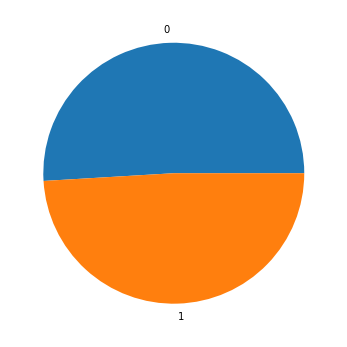

In [5]:
# function to check for data imbalance
def plot_data_balance(df):
    plt.figure(figsize=(12,6))
    plt.pie(df["Choice"].value_counts().values,labels=["0","1"])
    
plot_data_balance(train_df)

Data is well balanced

## Check uniqueness of users

* Check whether users (A and B) are unique
* Situations where a certain dependence between the rows exist, e.g.: A1 > B1 > A3 ..., might occur
* First check the duplication in the training dataset

In [6]:
# Check the dublication in the initial data
print('Duplications: {}'.format(train_df.duplicated().sum()))

Duplications: 132


In [7]:
# drop the duplications:
train_df.drop_duplicates(inplace=True)
#Check:
print('Unique rows: {}'.format(len(train_df)))
train_df.shape

Unique rows: 5368


(5368, 23)

* Thus 5368 rows are unique in the training dataset
* Now it can be split into A part and B part 

In [8]:
# Split the dataset into A and B
A_train_df = train_df.iloc[:,1:12]
B_train_df = train_df.iloc[:,12:]
# Check the columns
print(A_train_df.columns,A_train_df.shape)
print(B_train_df.columns,B_train_df.shape)

Index(['A_follower_count', 'A_following_count', 'A_listed_count',
       'A_mentions_received', 'A_retweets_received', 'A_mentions_sent',
       'A_retweets_sent', 'A_posts', 'A_network_feature_1',
       'A_network_feature_2', 'A_network_feature_3'],
      dtype='object') (5368, 11)
Index(['B_follower_count', 'B_following_count', 'B_listed_count',
       'B_mentions_received', 'B_retweets_received', 'B_mentions_sent',
       'B_retweets_sent', 'B_posts', 'B_network_feature_1',
       'B_network_feature_2', 'B_network_feature_3'],
      dtype='object') (5368, 11)


* Determine the number of unique users "A" and "B" and assign them unique id

In [9]:
#Check the unique
def get_unique_users(df,user):
    unique = df.drop_duplicates()
    print(user + " unique {} out of {}".format(len(unique),len(df)))
    # Assign the id
    unique[user+'_id'] = range(0,len(unique))
    print('Unique ' + user + ' are assigned id: ' + user +'_id')
    return unique

A_unique = get_unique_users(A_train_df,'A')
B_unique = get_unique_users(B_train_df,'B')

A unique 786 out of 5368
Unique A are assigned id: A_id
B unique 788 out of 5368
Unique B are assigned id: B_id


* Next step is to find the trully unique users, i.e. unique among the unique "A" and unique "B"

In [10]:
# Rename Columns from A to B to concatenate the DFs
A_unique_toB = A_unique.copy()
A_unique_toB.rename(columns=dict(zip(A_unique.columns, B_unique.columns)),inplace=True)

In [11]:
# concatenate two DFs and find uniques
B_unique_merged = pd.concat([B_unique,A_unique_toB])
# drop the B_id column to find uniques
B_unique_merged.drop(columns=['B_id'],inplace=True)
B_unique_merged_unique = get_unique_users(B_unique_merged,'unique')

unique unique 1172 out of 1574
Unique unique are assigned id: unique_id


* Thus 1172 unique A/B users are in the training dataset
* Incorporate this information into the dataset, as this can be important for the future feature engineering

In [12]:
# Function to merge the DF with unique users and the general DF.
def identify_unique(full_df,unique_df,columns,user):
    out_df = pd.merge(unique_df,full_df,on=list(columns),left_index=True)
    out_df.rename(columns={'unique_id' : user + '_unique_id'},inplace=True)
    return out_df

# Merge and identify B-unique
train_df = identify_unique(train_df,B_unique_merged_unique,B_unique_merged_unique.columns[:-1],'B')

# rename the unique DF from B to A. 
A_unique_merged_unique = B_unique_merged_unique.rename(columns=dict(zip(B_unique.columns[:-1], A_unique.columns[:-1])))
# Merge and identify A-unique
train_df = identify_unique(train_df,A_unique_merged_unique,A_unique.columns[:-1],'A')
print(train_df.columns,train_df.shape)

Index(['A_follower_count', 'A_following_count', 'A_listed_count',
       'A_mentions_received', 'A_retweets_received', 'A_mentions_sent',
       'A_retweets_sent', 'A_posts', 'A_network_feature_1',
       'A_network_feature_2', 'A_network_feature_3', 'A_unique_id',
       'B_follower_count', 'B_following_count', 'B_listed_count',
       'B_mentions_received', 'B_retweets_received', 'B_mentions_sent',
       'B_retweets_sent', 'B_posts', 'B_network_feature_1',
       'B_network_feature_2', 'B_network_feature_3', 'B_unique_id', 'Choice'],
      dtype='object') (5368, 25)


In [13]:
# sort by the index
train_df.sort_index(inplace=True)
# and drop the index column
print(train_df.columns,train_df.shape)
train_df.tail()

Index(['A_follower_count', 'A_following_count', 'A_listed_count',
       'A_mentions_received', 'A_retweets_received', 'A_mentions_sent',
       'A_retweets_sent', 'A_posts', 'A_network_feature_1',
       'A_network_feature_2', 'A_network_feature_3', 'A_unique_id',
       'B_follower_count', 'B_following_count', 'B_listed_count',
       'B_mentions_received', 'B_retweets_received', 'B_mentions_sent',
       'B_retweets_sent', 'B_posts', 'B_network_feature_1',
       'B_network_feature_2', 'B_network_feature_3', 'B_unique_id', 'Choice'],
      dtype='object') (5368, 25)


,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,A_network_feature_2,...,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3,B_unique_id,Choice
5495,41765,185,1356,1529.643058,282.858500,76.809514,5.392171,104.438625,3307,50.132042,...,6881.482996,5013.642295,22.683131,2.385538,18.420981,23958,21.324988,1413.825398,333,0
5496,112,243,5,1.445174,0.100503,0.100503,0.100503,0.603177,5,96.600000,...,0.306073,0.306073,0.100503,0.100503,1.621981,1,49.000000,4969.000000,46,1
5497,15385,673,747,55.993546,22.321945,6.946233,0.341936,6.503977,202,152.495098,...,21.601866,3.581661,6.764657,1.119727,4.563246,85,48.500000,1993.627907,4,0
5498,265258,209,551,631.915946,457.648550,5.460985,0.100503,7.498126,2603,3.826314,...,176.533716,42.330221,6.849227,1.345073,4.359865,696,234.338068,7168.464489,10,0
5499,628,921,6,3.943848,0.618590,4.769930,0.870136,2.953237,8,210.625000,...,311.800311,142.633229,4.486090,1.049408,4.806823,1280,48.532819,1554.489575,84,0


## Check for the outliers

### Pairwise relationships in a dataset

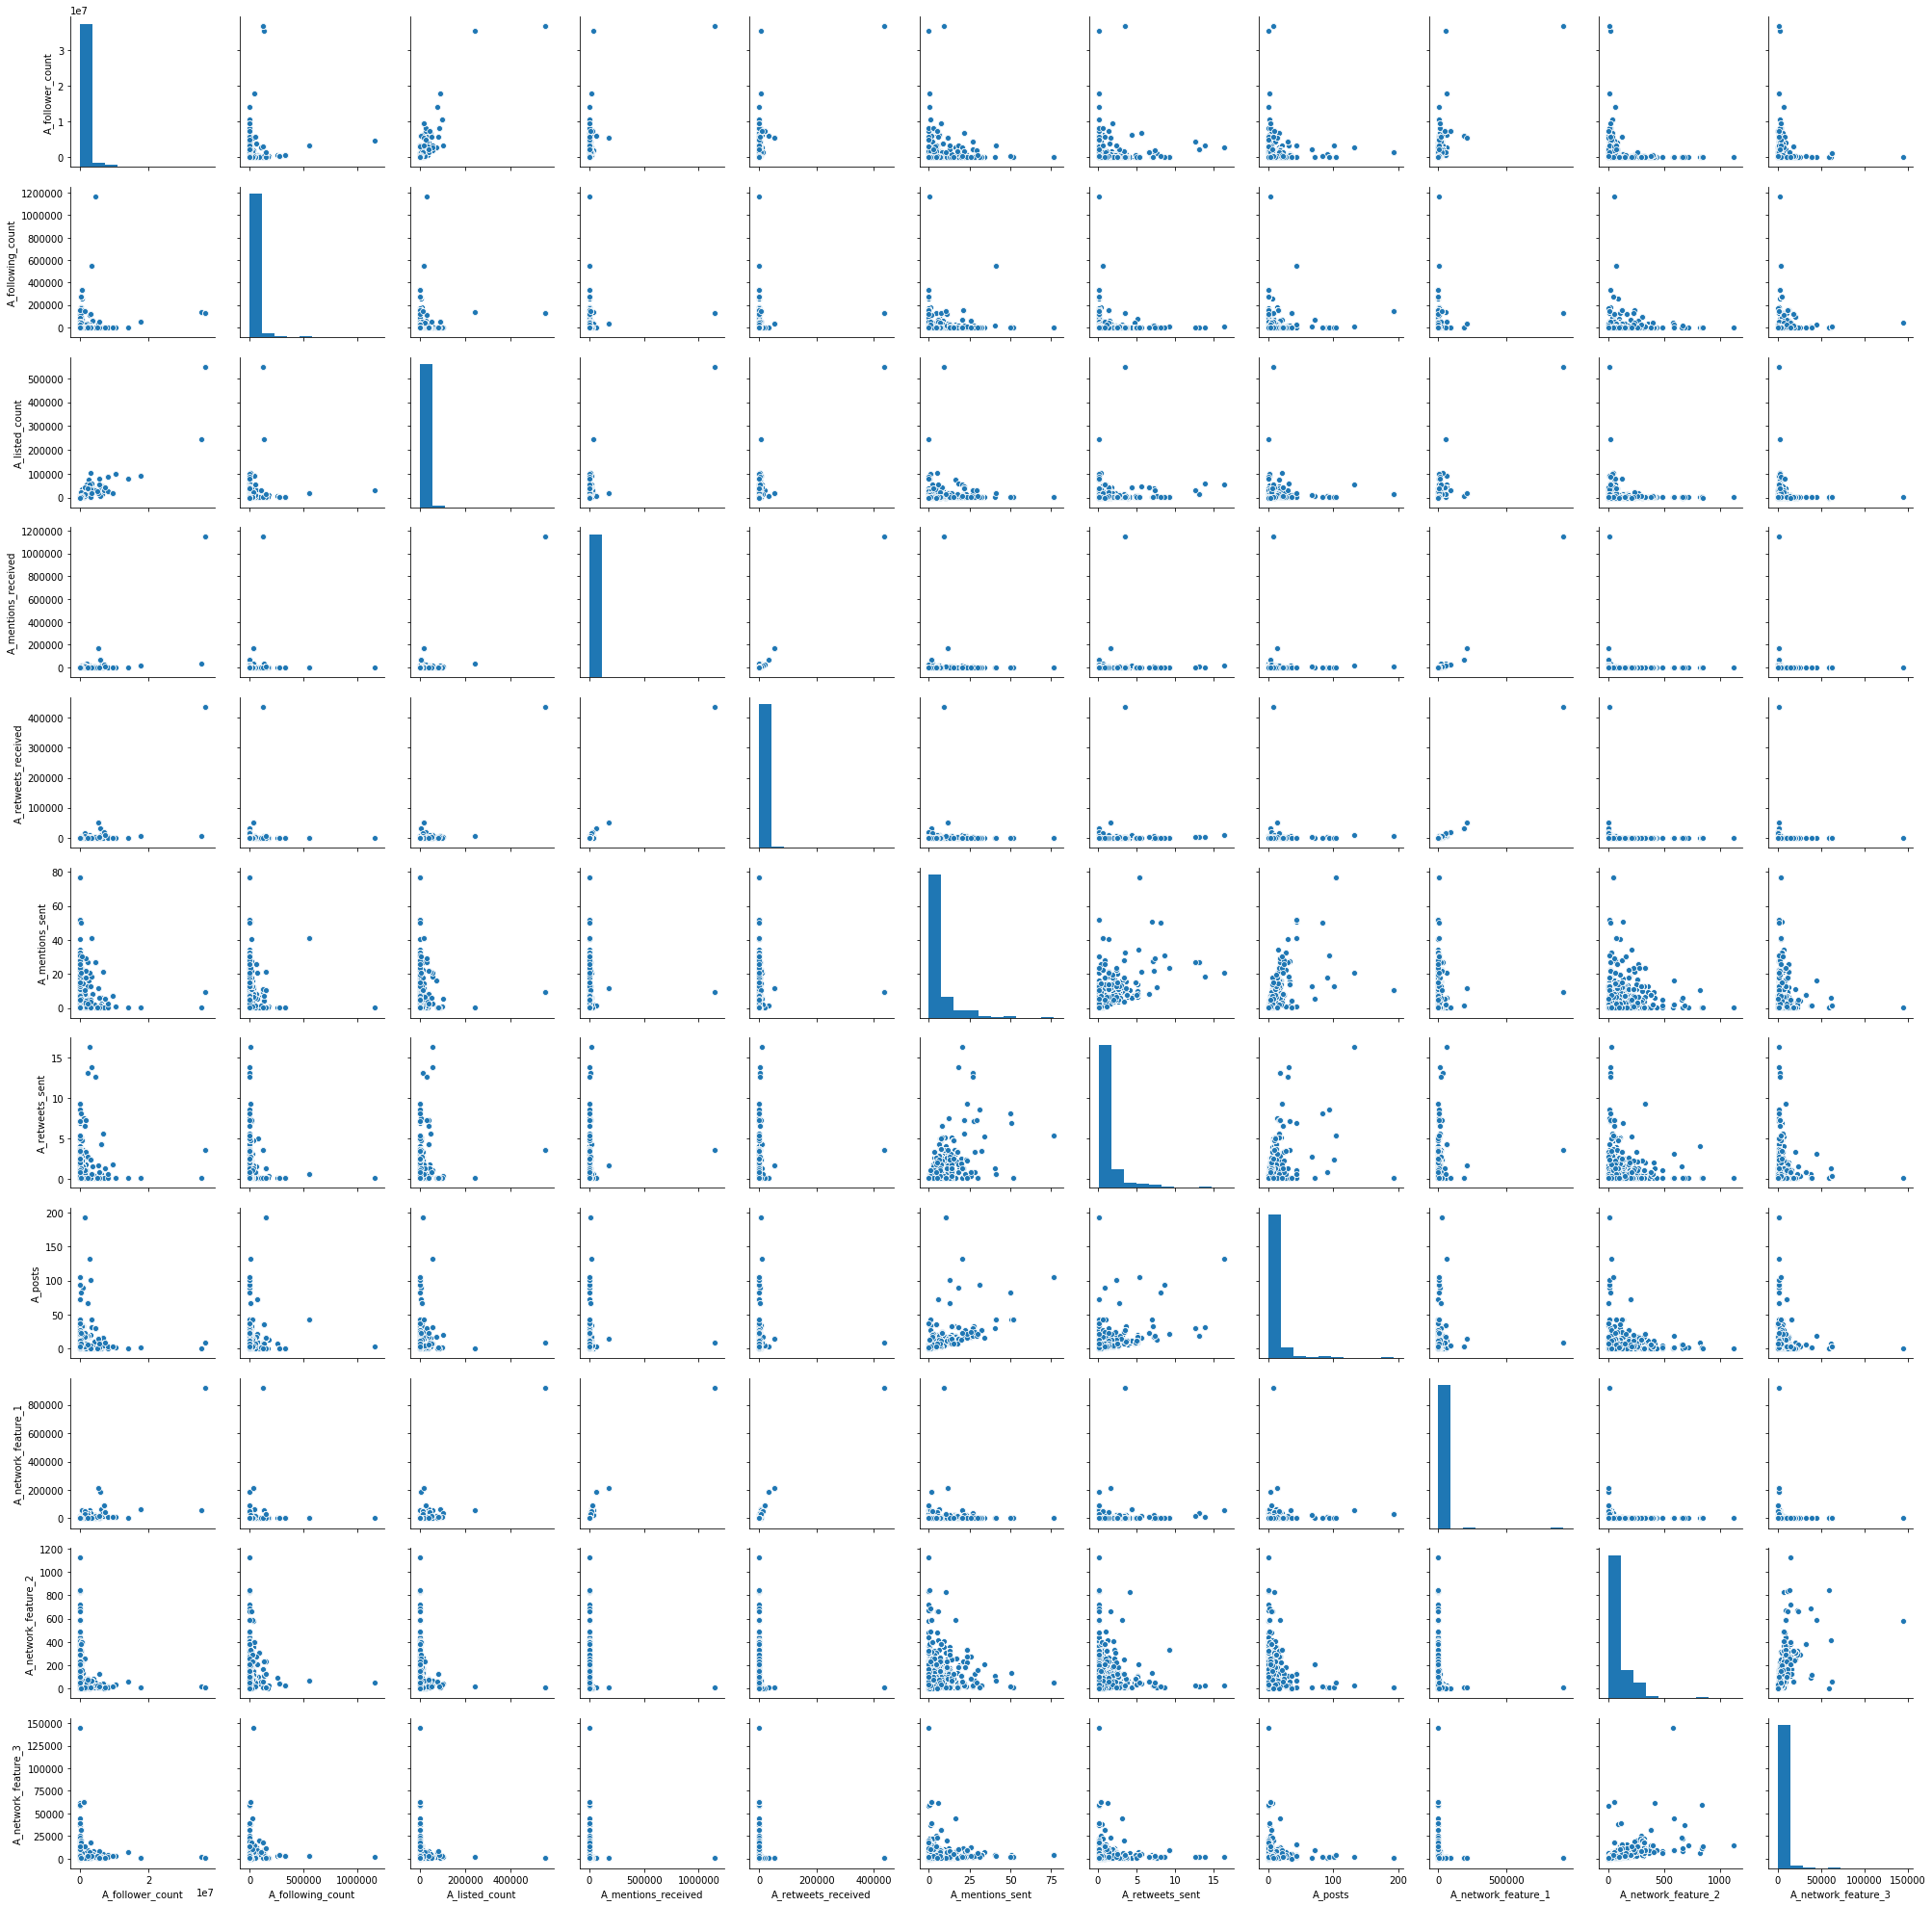

In [14]:
# Useful to see the general picture
sns.pairplot(train_df.loc[:,'A_follower_count':'A_network_feature_3']);

### Closer look using standard plotting methods

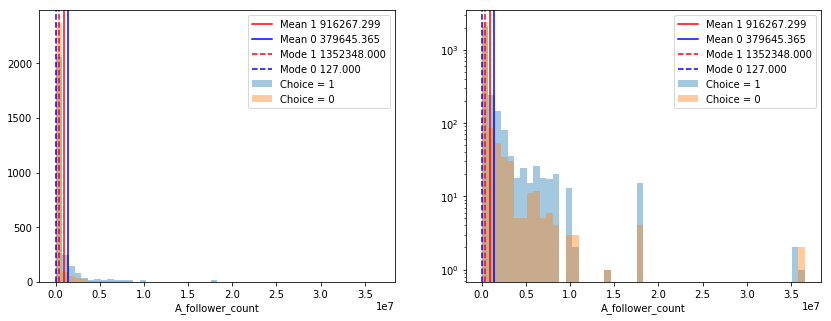

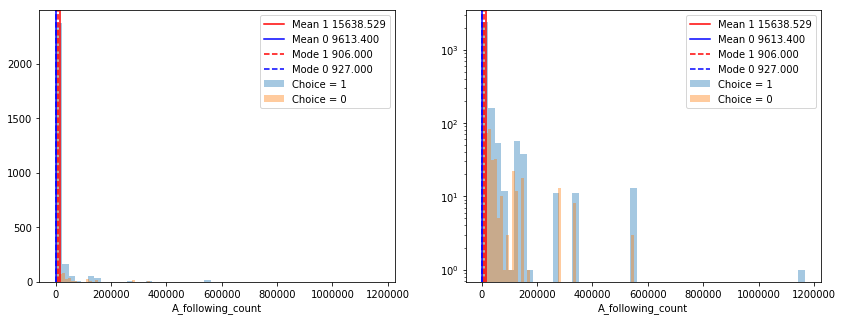

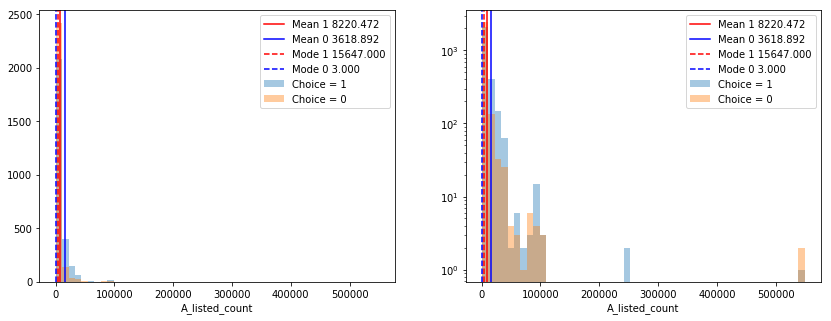

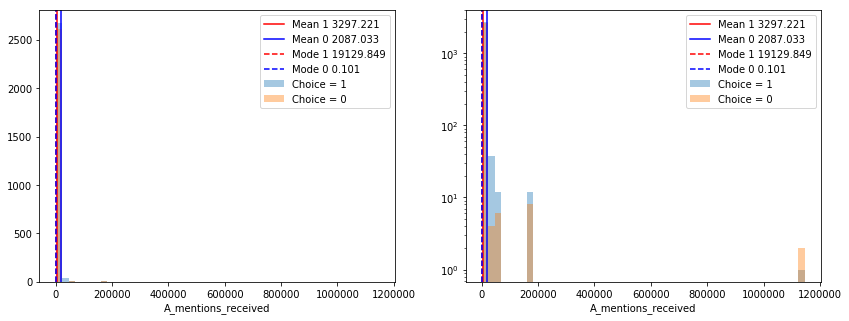

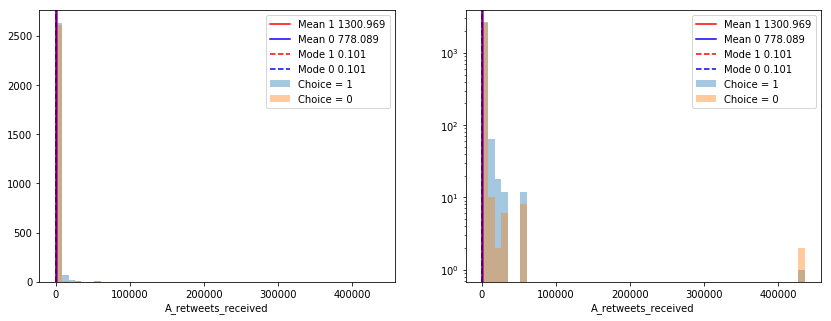

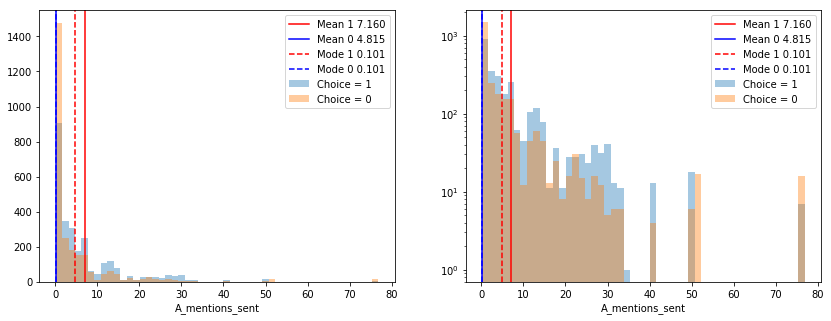

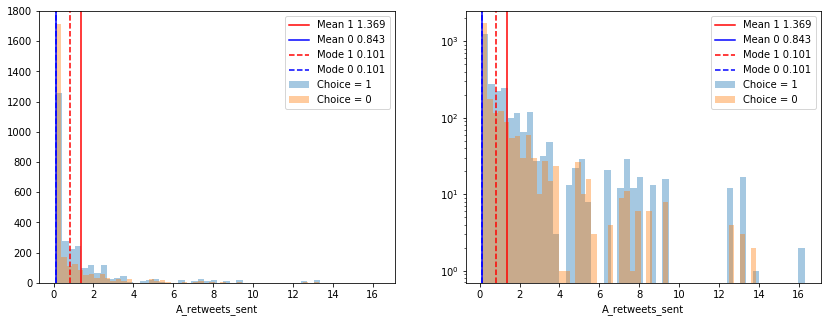

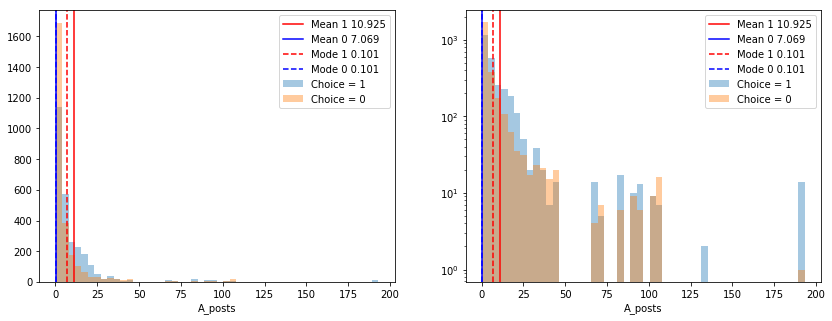

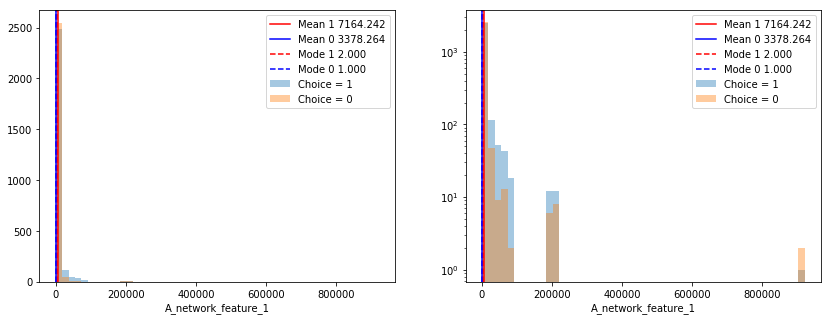

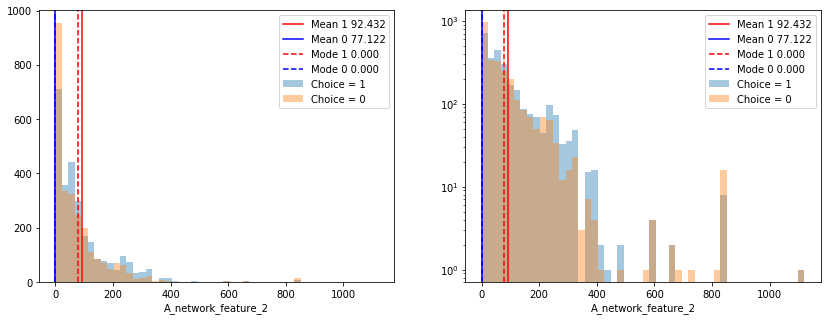

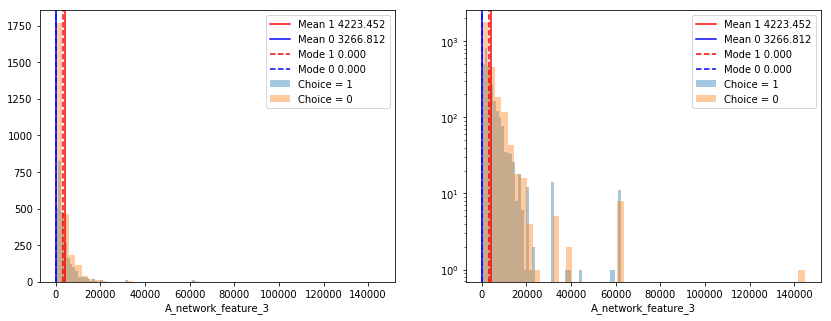

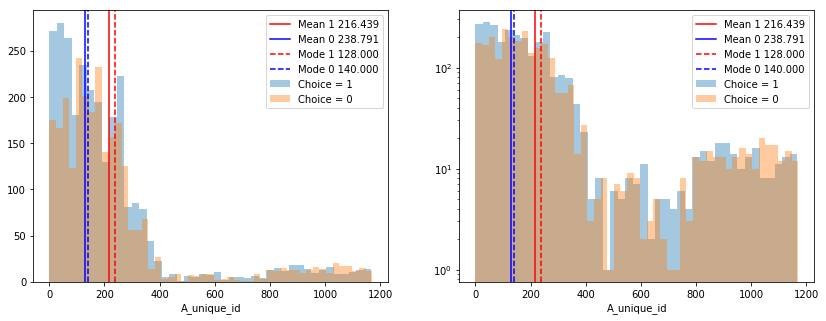

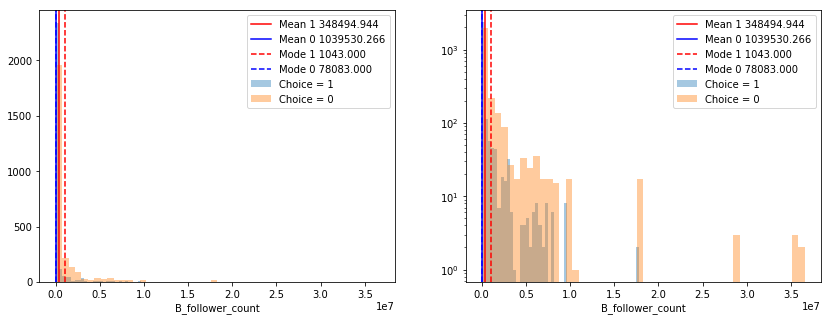

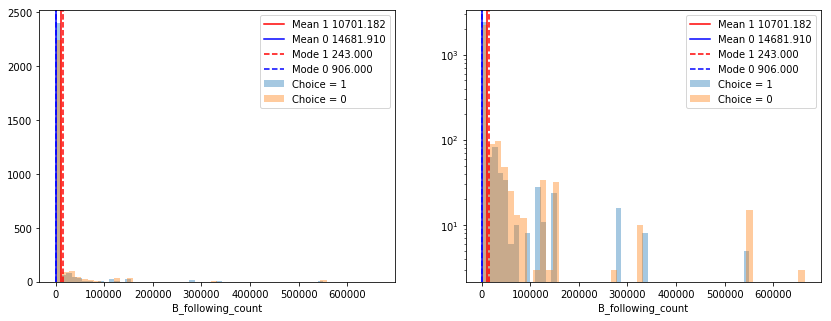

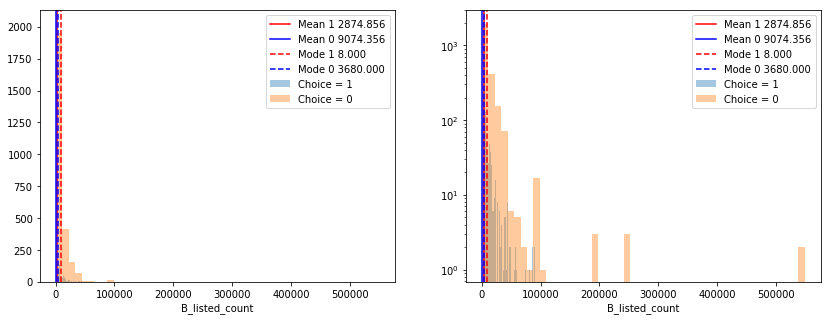

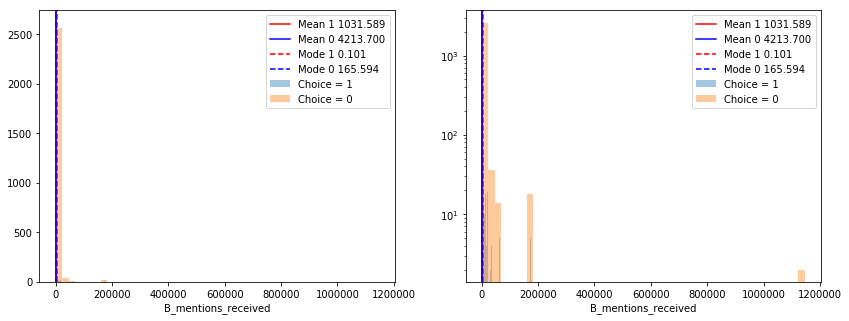

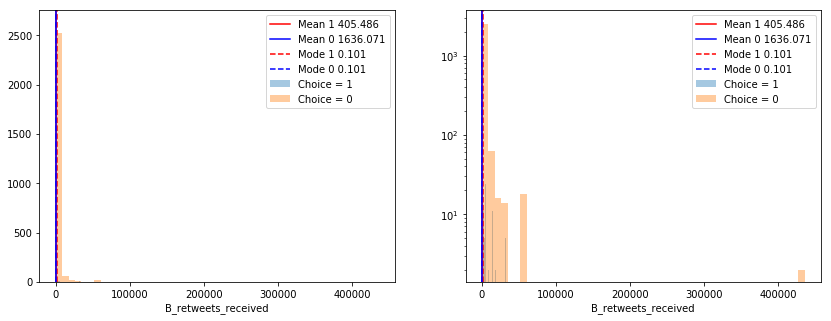

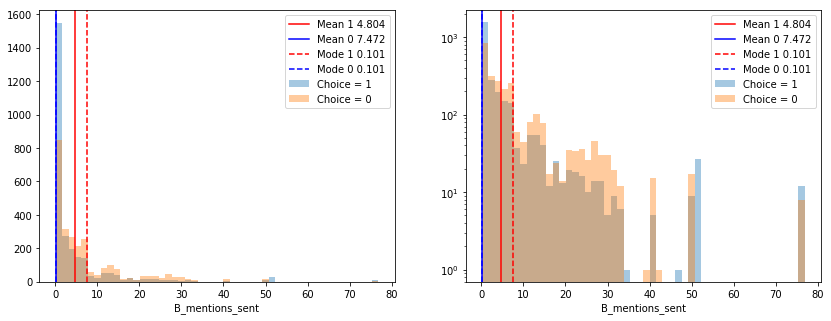

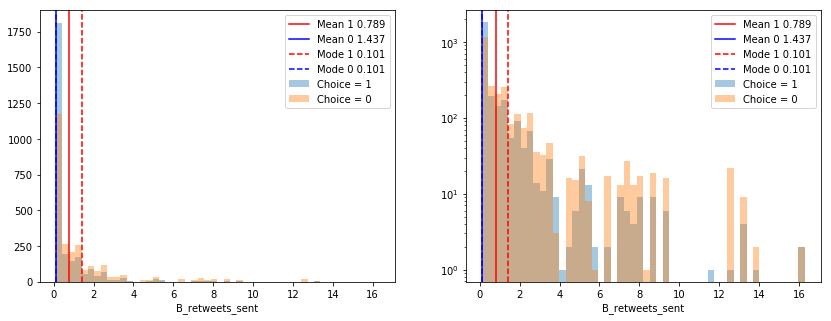

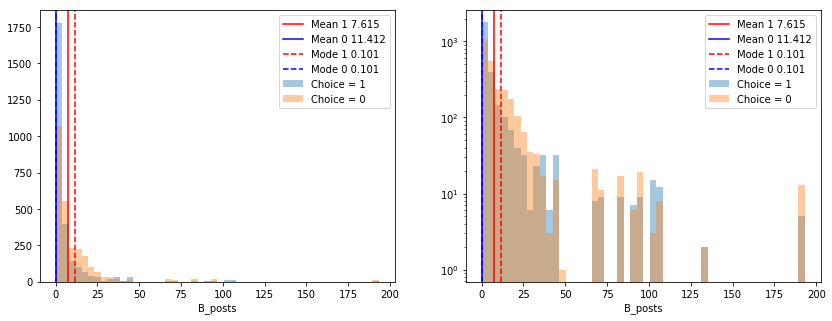

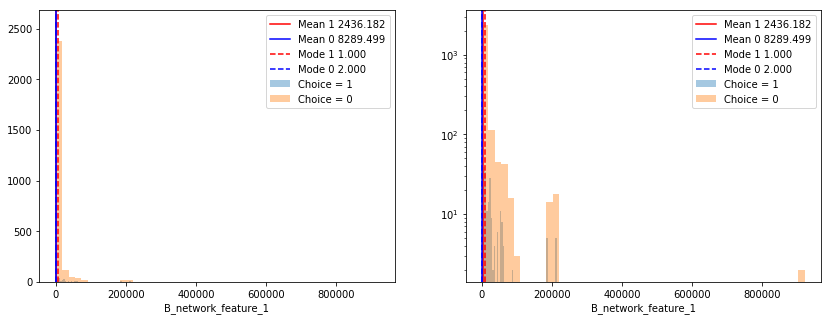

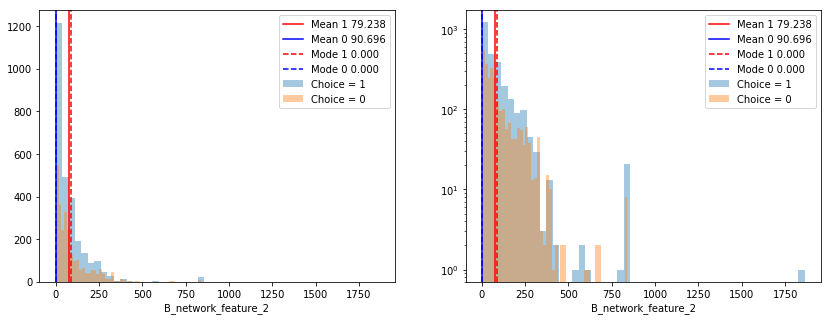

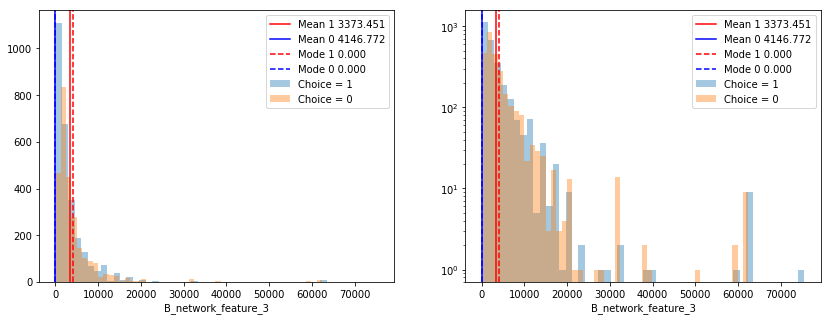

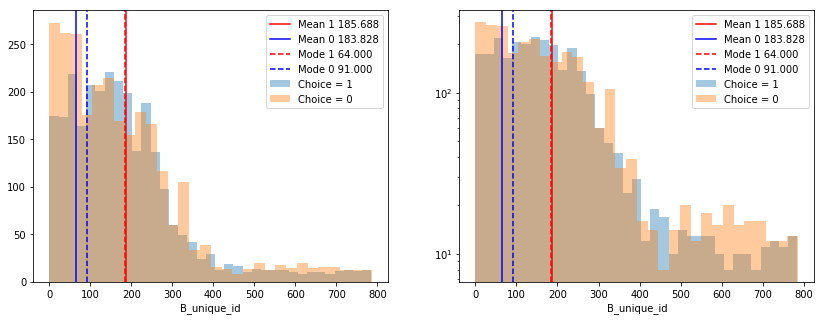

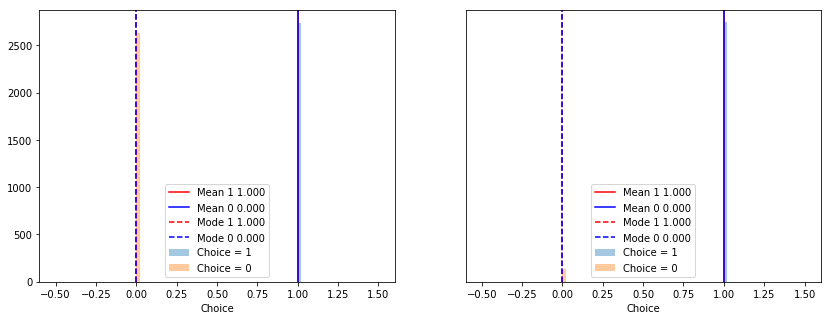

In [15]:
# Plot the features 
for i, col in enumerate(train_df.columns,start=1):
    plt.figure(i,figsize=(14, 5))
    
    #
    feature1 = train_df.loc[train_df['Choice'] == 1,col]
    feature0 = train_df.loc[train_df['Choice'] == 0,col]
    
    # compute stats for the distributions
    mean1=feature1.mean()
    mode1=feature1.mode().get_values()[0]
    mean0=feature0.mean()
    mode0=feature0.mode().get_values()[0]

    # distribution of each feature
    plt.subplot(1, 2, 1)
    sns.distplot(feature1,kde=False)
    sns.distplot(feature0,kde=False)
    #sns.distplot(train_df[col],kde=False)
    plt.axvline(mean1, color='r', linestyle='-')
    plt.axvline(mode1, color='b', linestyle='-')
    plt.axvline(mean0, color='r', linestyle='--')
    plt.axvline(mode0, color='b', linestyle='--')
    plt.legend({'Mean 1 {:0.3f}'.format(mean1):mean1,
                'Mean 0 {:0.3f}'.format(mean0):mean0,
                'Mode 1 {:0.3f}'.format(mode1):mode1,
                'Mode 0 {:0.3f}'.format(mode0):mode0,
                'Choice = 1':feature1,
                'Choice = 0':feature0
               })
    
    # Add log-y plot to better see the low populated regions
    plt.subplot(1, 2, 2)
    sns.distplot(feature1,kde=False)
    ax = sns.distplot(feature0,kde=False)
    ax.set_yscale('log')
    plt.axvline(mean1, color='r', linestyle='-')
    plt.axvline(mode1, color='b', linestyle='-')
    plt.axvline(mean0, color='r', linestyle='--')
    plt.axvline(mode0, color='b', linestyle='--')
    plt.legend({'Mean 1 {:0.3f}'.format(mean1):mean1,
                'Mean 0 {:0.3f}'.format(mean0):mean0,
                'Mode 1 {:0.3f}'.format(mode1):mode1,
                'Mode 0 {:0.3f}'.format(mode0):mode0,
                'Choice = 1':feature1,
                'Choice = 0':feature0
               })

* Two previous steps show that there are a number of candidates for outliers, i.e. many low populated areas/individual points at large values of the features.
* However, to not remove important data, more detailed analysis has to be done, e.g. using the Isolation forest method
* None of the variables itself can be used as a single descriminator due to a similarity of the shapes for 0 and 1

### Isolation forest to identify the outliers

In [16]:
#Standard implementation of the IsolationForest algorithm
isolation_forest = IsolationForest(n_estimators=100,random_state=1,behaviour='new')
isolation_forest.fit(train_df)

IsolationForest(behaviour='new', bootstrap=False, contamination='legacy',
        max_features=1.0, max_samples='auto', n_estimators=100,
        n_jobs=None, random_state=1, verbose=0)

Predicted 537 outliers


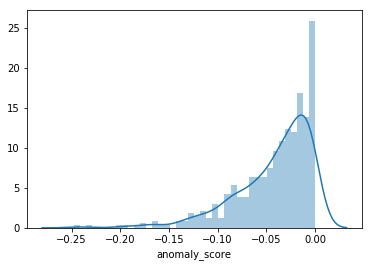

In [17]:
# get the outliers predicted by the algorithms
predict_outliers = isolation_forest.predict(train_df)

# getting the anomaly scores
anomaly_score = isolation_forest.decision_function(train_df)

train_df['predict_outliers'] = predict_outliers
train_df['anomaly_score'] = anomaly_score

myplt = sns.distplot(train_df.loc[train_df['predict_outliers'] == -1,'anomaly_score'],bins=40)
print('Predicted {} outliers'.format(np.unique(predict_outliers,return_counts=True)[1][0]))

* Predicted number of outliers is large;
* Study the feature distributions again to see how they look for the outliers and inliers and whether a certain conclusion can be drawn.

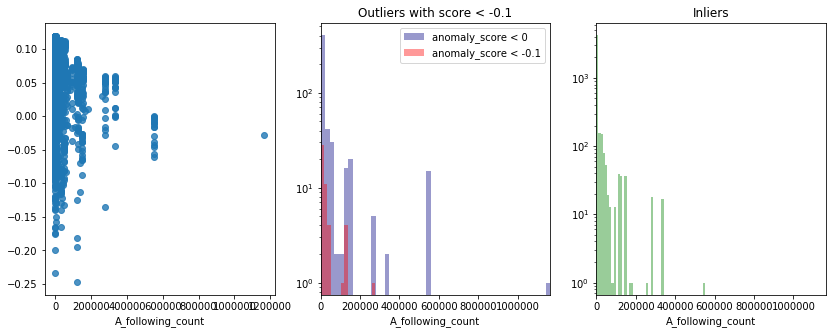

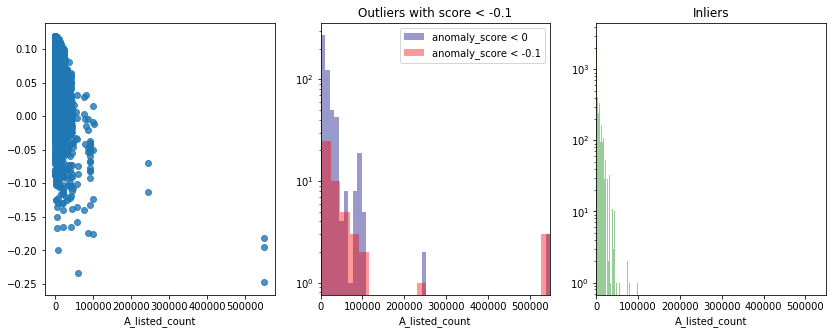

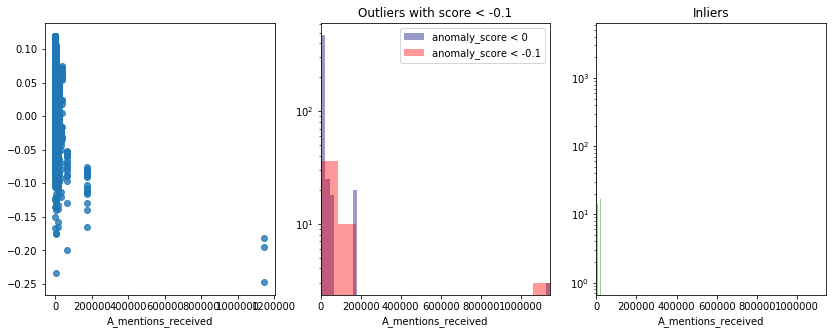

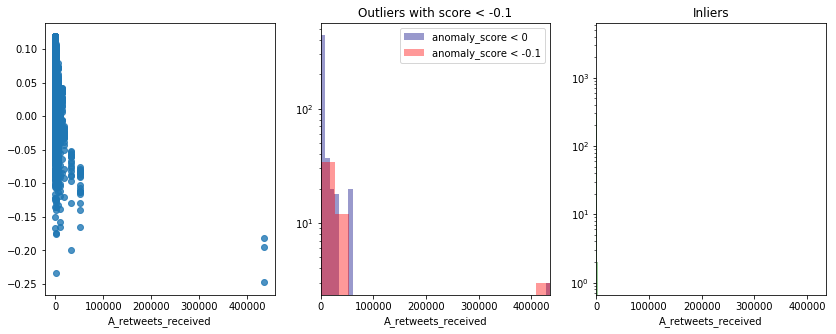

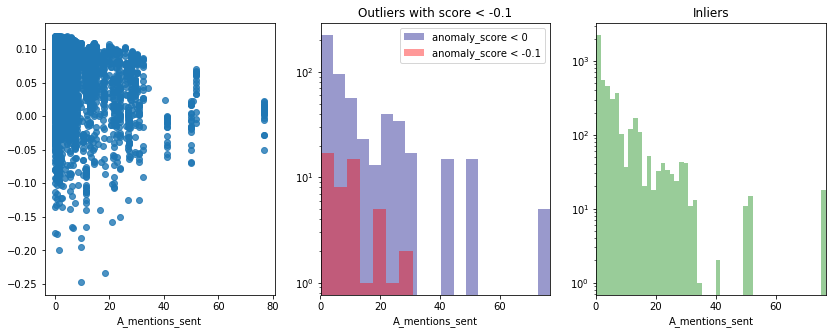

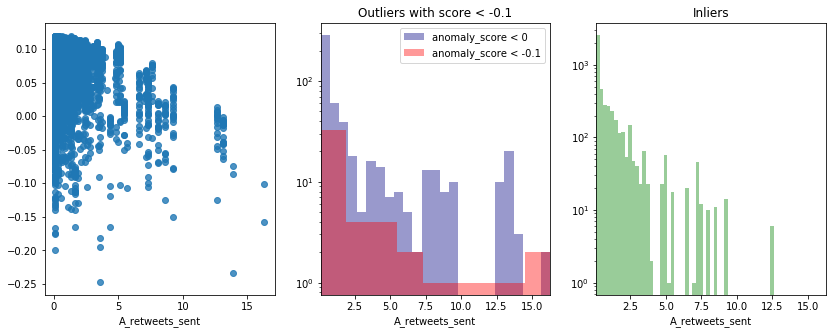

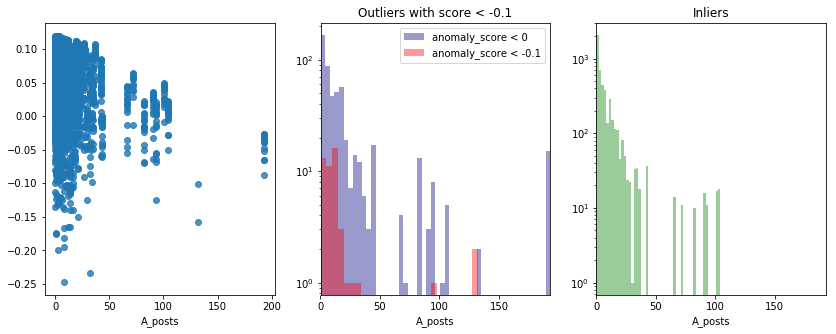

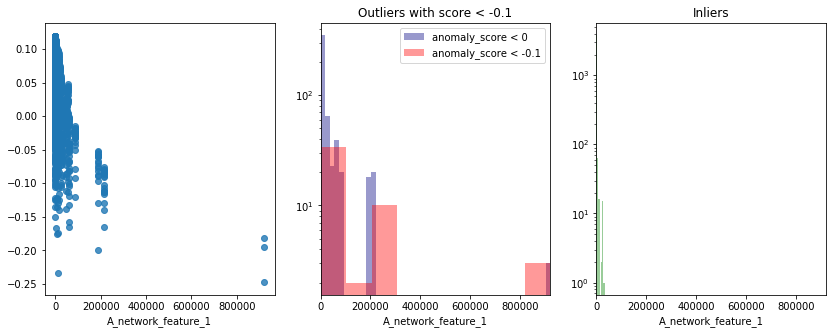

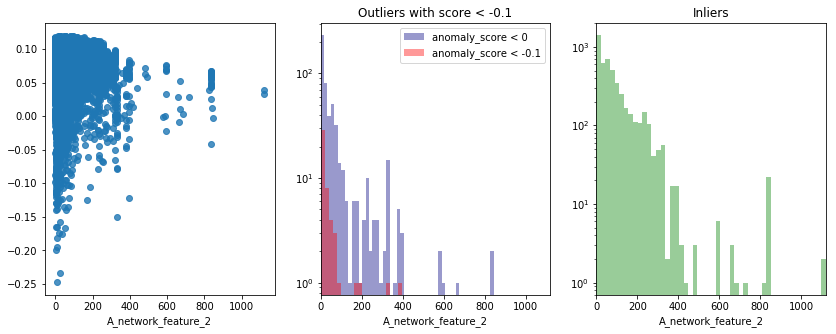

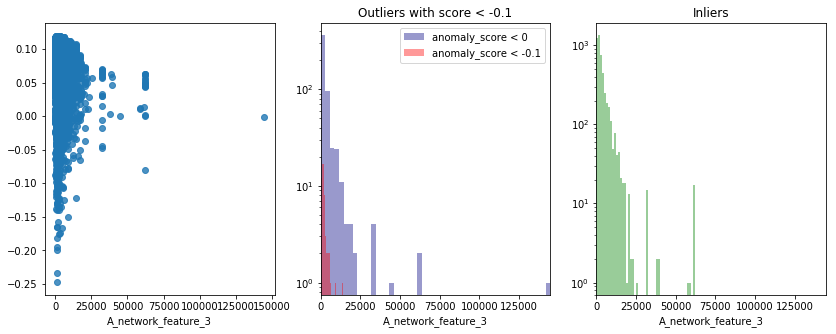

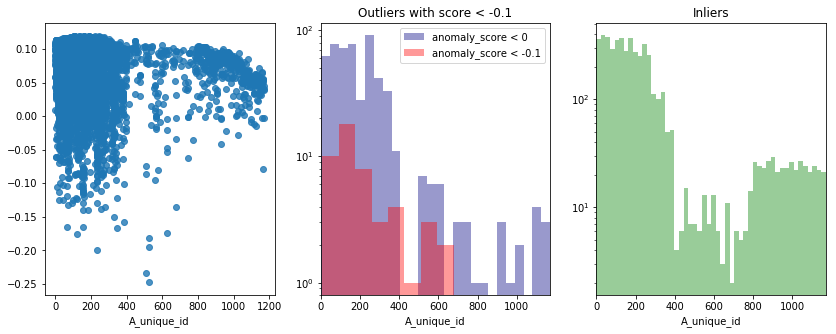

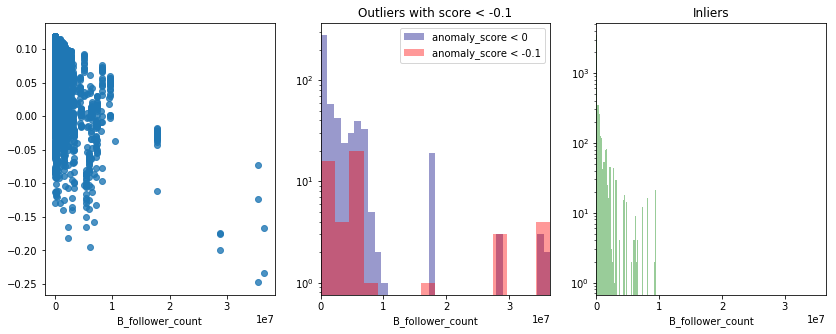

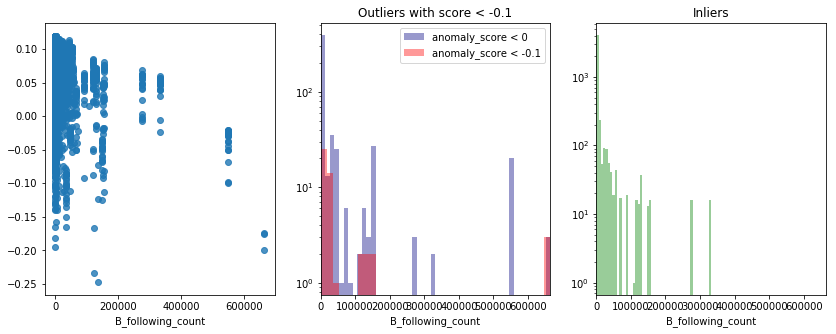

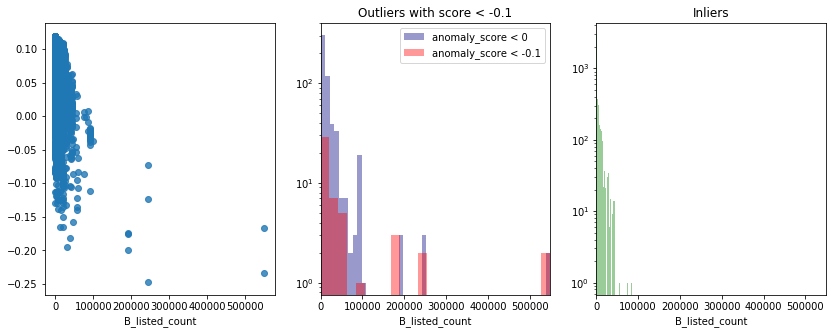

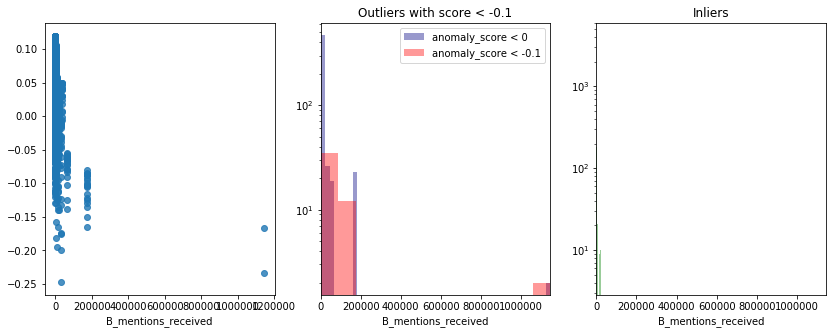

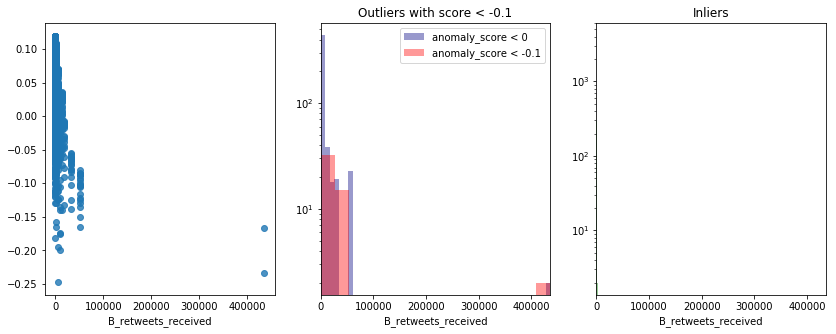

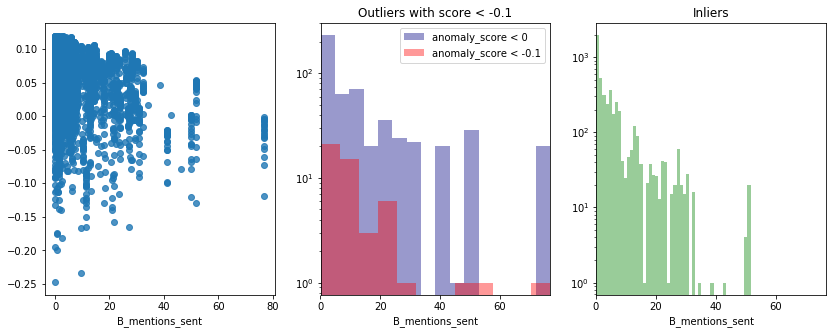

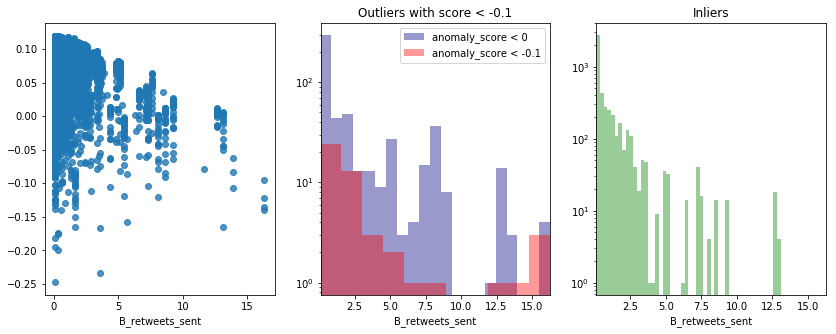

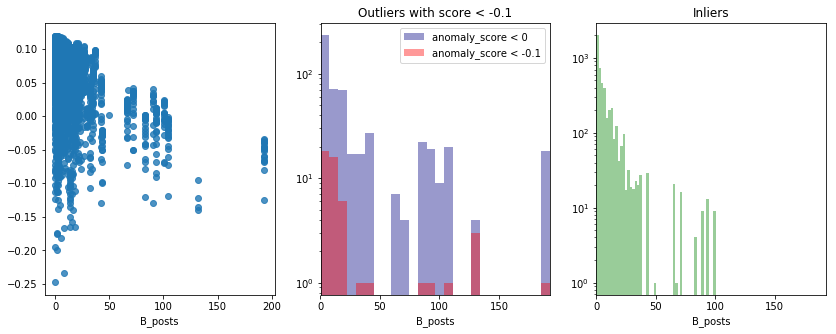

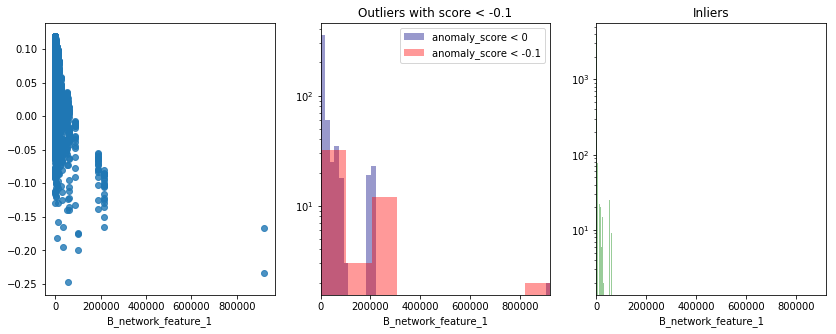

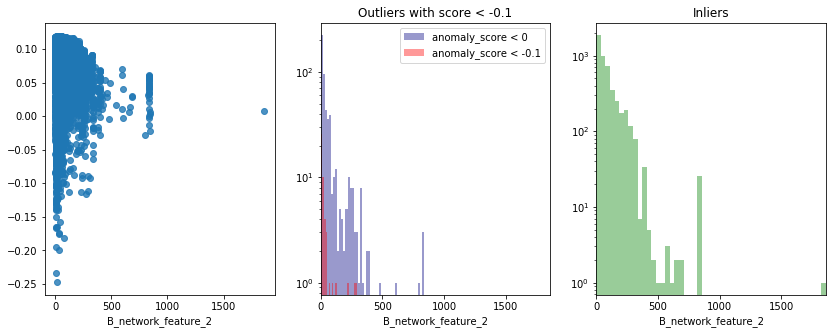

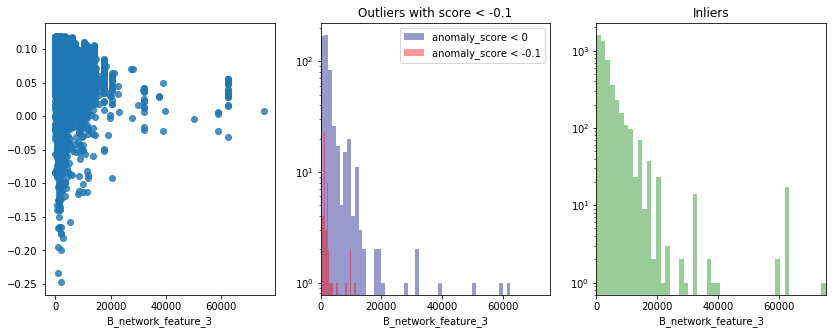

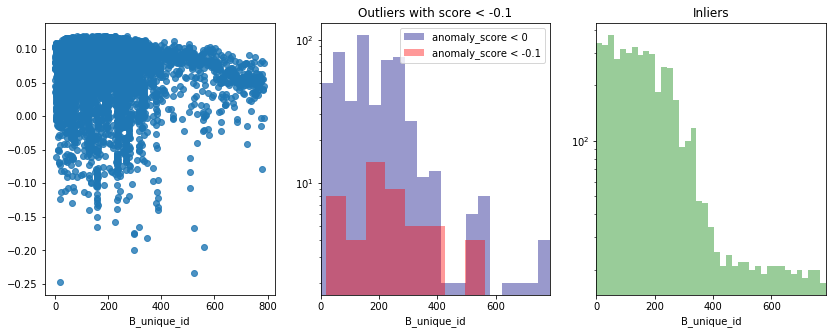

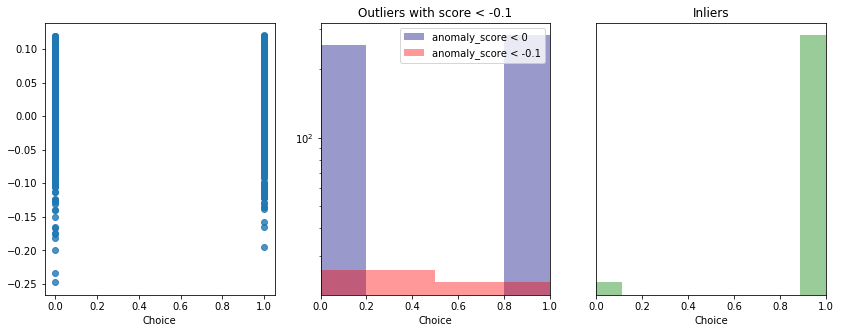

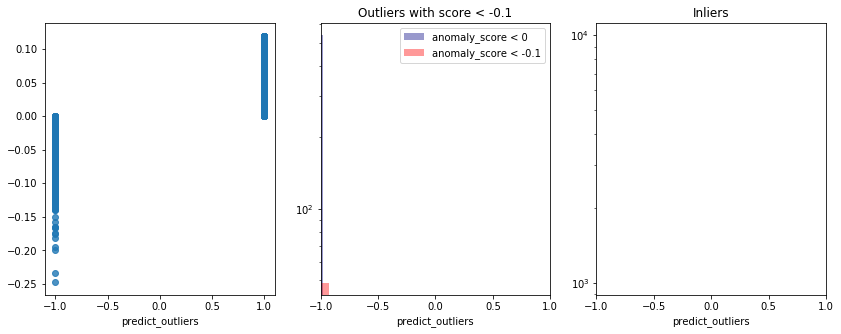

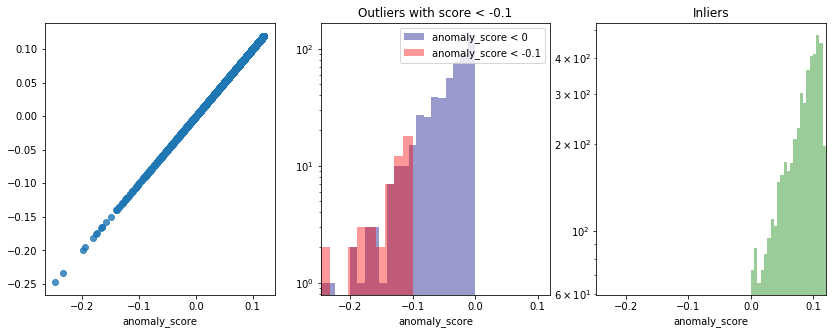

In [18]:
for col in train_df.columns[1:]:
    plt.figure(figsize=(14, 5))
    #get maximum and minimum values to control the x-axis range
    xmin = train_df[col].min()
    xmax = train_df[col].max()
    
    # plotting the anomaly scores for all the variables
    plt.subplot(1, 3, 1)
    sns.regplot(train_df[col], anomaly_score, label='anomaly score',fit_reg=False)
    
    # Distribution of the ouliers
    plt.subplot(1, 3, 2)
    ax = sns.distplot(train_df.loc[train_df['predict_outliers'] == -1,col],kde=False,color='navy',label='anomaly_score < 0')
    sns.distplot(train_df.loc[train_df['anomaly_score'] < -0.1,col],kde=False,color='red',ax=ax,label='anomaly_score < -0.1')
    ax.set_title('Outliers with score < -0.1')
    ax.set_yscale('log')
    plt.xlim(xmin, xmax)
    ax.legend(loc='best')
    
    # Distribution of the inliers
    plt.subplot(1, 3, 3)
    ax = sns.distplot(train_df.loc[train_df['predict_outliers'] == 1,col],kde=False,color='green')
    ax.set_title('Inliers')
    ax.set_yscale('log')
    plt.xlim(xmin, xmax)

* In many cases the behaviour of outliers with anomaly scores < -0.1 coincides with the expectations from the visual analysis;
* Thus, drop the rows where anomaly scores < -0.1 for improvement of prediction power

### Drop the outliers

In [19]:
# Drop the outliers
train_df = train_df[train_df['anomaly_score']>-0.1]
# Check the result
print((train_df['anomaly_score'] < -0.1).any())
#And drop the columns
train_df.drop(columns=['anomaly_score','predict_outliers'],inplace=True)

False


In [20]:
print(train_df.shape)
train_df.head()

(5319, 25)


,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,A_network_feature_2,...,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3,B_unique_id,Choice
0,228,302,3,0.583979,0.100503,0.100503,0.100503,0.362150,2,166.500000,...,15.430498,3.984029,8.204331,0.332423,6.988815,66,75.530303,1916.893939,0,0
1,21591,1179,228,90.456506,25.798292,5.709329,1.111159,5.176620,369,18.442971,...,40.495021,8.943607,3.227677,0.564343,1.070321,163,132.030675,2931.515337,1,0
2,7310,1215,101,25.503644,9.556347,5.361519,0.591206,3.589718,95,68.927835,...,0.734696,0.354379,0.603202,0.100503,0.603202,3,10.333333,277.333333,2,0
3,20,7,2,7.690824,0.277306,1.331508,0.100503,2.830627,6,2.000000,...,572.874856,390.293681,27.552040,7.167557,32.101906,1762,23.469296,1395.845634,3,0
4,45589,862,2641,148.854279,36.998884,27.881768,3.333492,23.861282,551,127.404293,...,21.601866,3.581661,6.764657,1.119727,4.563246,85,48.500000,1993.627907,4,1


## Study the network

* The interactions between A and B candidates 

In [21]:
# Compute the number of total interactions for each user 
def get_user_interactions(df,user):
    # count number of interactios for each unique id
    df_counts = df[user + '_unique_id'].value_counts(sort=False).to_frame()
    df_counts.rename(columns={user + '_unique_id' : user + '_interactions_count'},inplace=True)
    # change the indexing
    df_counts[user + '_unique_id'] = df_counts.index
    out = pd.merge(df_counts,df,on=[user + '_unique_id'],left_index=True)
    out.sort_index(inplace=True)
    print('New column "' + user + '_interactions_count" is added to the dataframe')
    return out

In [22]:
# Add interaction columns for each user
for user in ['A','B']:
    train_df = get_user_interactions(train_df,user)
# And check
print(train_df.columns)

New column "A_interactions_count" is added to the dataframe
New column "B_interactions_count" is added to the dataframe
Index(['B_interactions_count', 'B_unique_id', 'A_interactions_count',
       'A_unique_id', 'A_follower_count', 'A_following_count',
       'A_listed_count', 'A_mentions_received', 'A_retweets_received',
       'A_mentions_sent', 'A_retweets_sent', 'A_posts', 'A_network_feature_1',
       'A_network_feature_2', 'A_network_feature_3', 'B_follower_count',
       'B_following_count', 'B_listed_count', 'B_mentions_received',
       'B_retweets_received', 'B_mentions_sent', 'B_retweets_sent', 'B_posts',
       'B_network_feature_1', 'B_network_feature_2', 'B_network_feature_3',
       'Choice'],
      dtype='object')


### Visualise the network

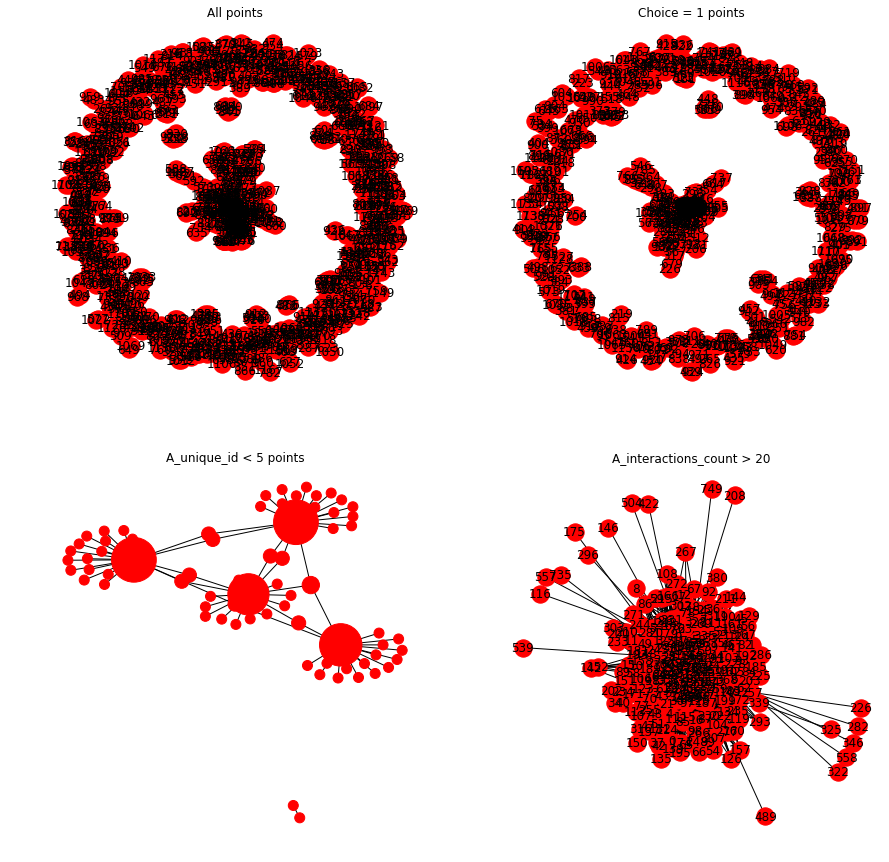

In [23]:
# Choose the variables to be involved into this study
network = train_df[['A_unique_id','B_unique_id','Choice','A_interactions_count','B_interactions_count','A_follower_count','A_following_count']]

# Build the graph for all points
plt.figure(figsize=(15,15))
plt.subplot(2, 2, 1)
G=nx.from_pandas_edgelist(network, 'A_unique_id', 'B_unique_id')
nx.draw(G,with_labels=True)
plt.title('All points')

# Reduce the amount of points and plot some subsets
# only for Choice=1
plt.subplot(2, 2, 2)
G_choice1=nx.from_pandas_edgelist(network.query('Choice == 1'), 'A_unique_id', 'B_unique_id')
nx.draw(G_choice1,with_labels=True)
plt.title('Choice = 1 points')

# For random n points
plt.subplot(2, 2, 3)
G_uniqueId=nx.from_pandas_edgelist(network.query('A_unique_id < 5'), 'A_unique_id', 'B_unique_id')
degree = G_uniqueId.degree()
nx.draw(G_uniqueId,node_size=[v * 100 for v in dict(degree).values()])
plt.title('A_unique_id < 5 points')

# For large number of interactions of A
plt.subplot(2, 2, 4)
G_largeA_inter=nx.from_pandas_edgelist(network.query('A_interactions_count > 20'), 'A_unique_id', 'B_unique_id')
nx.draw(G_largeA_inter,with_labels=True)
plt.title('A_interactions_count > 20')

plt.show()

* There is a clear cluster structure in the data 
* Many clusters with a lot of connections they are representing well-known users, "celebrities"
* This information might be incorporated as a new feature using one of the clustering algorithms

In [24]:
# Save the network for further investigation
train_df.to_csv('Network.csv')

## Check the correlations

The correlation map helps to understand relations between the different features and thus provides the guidance on how to prepare them for the modeling.

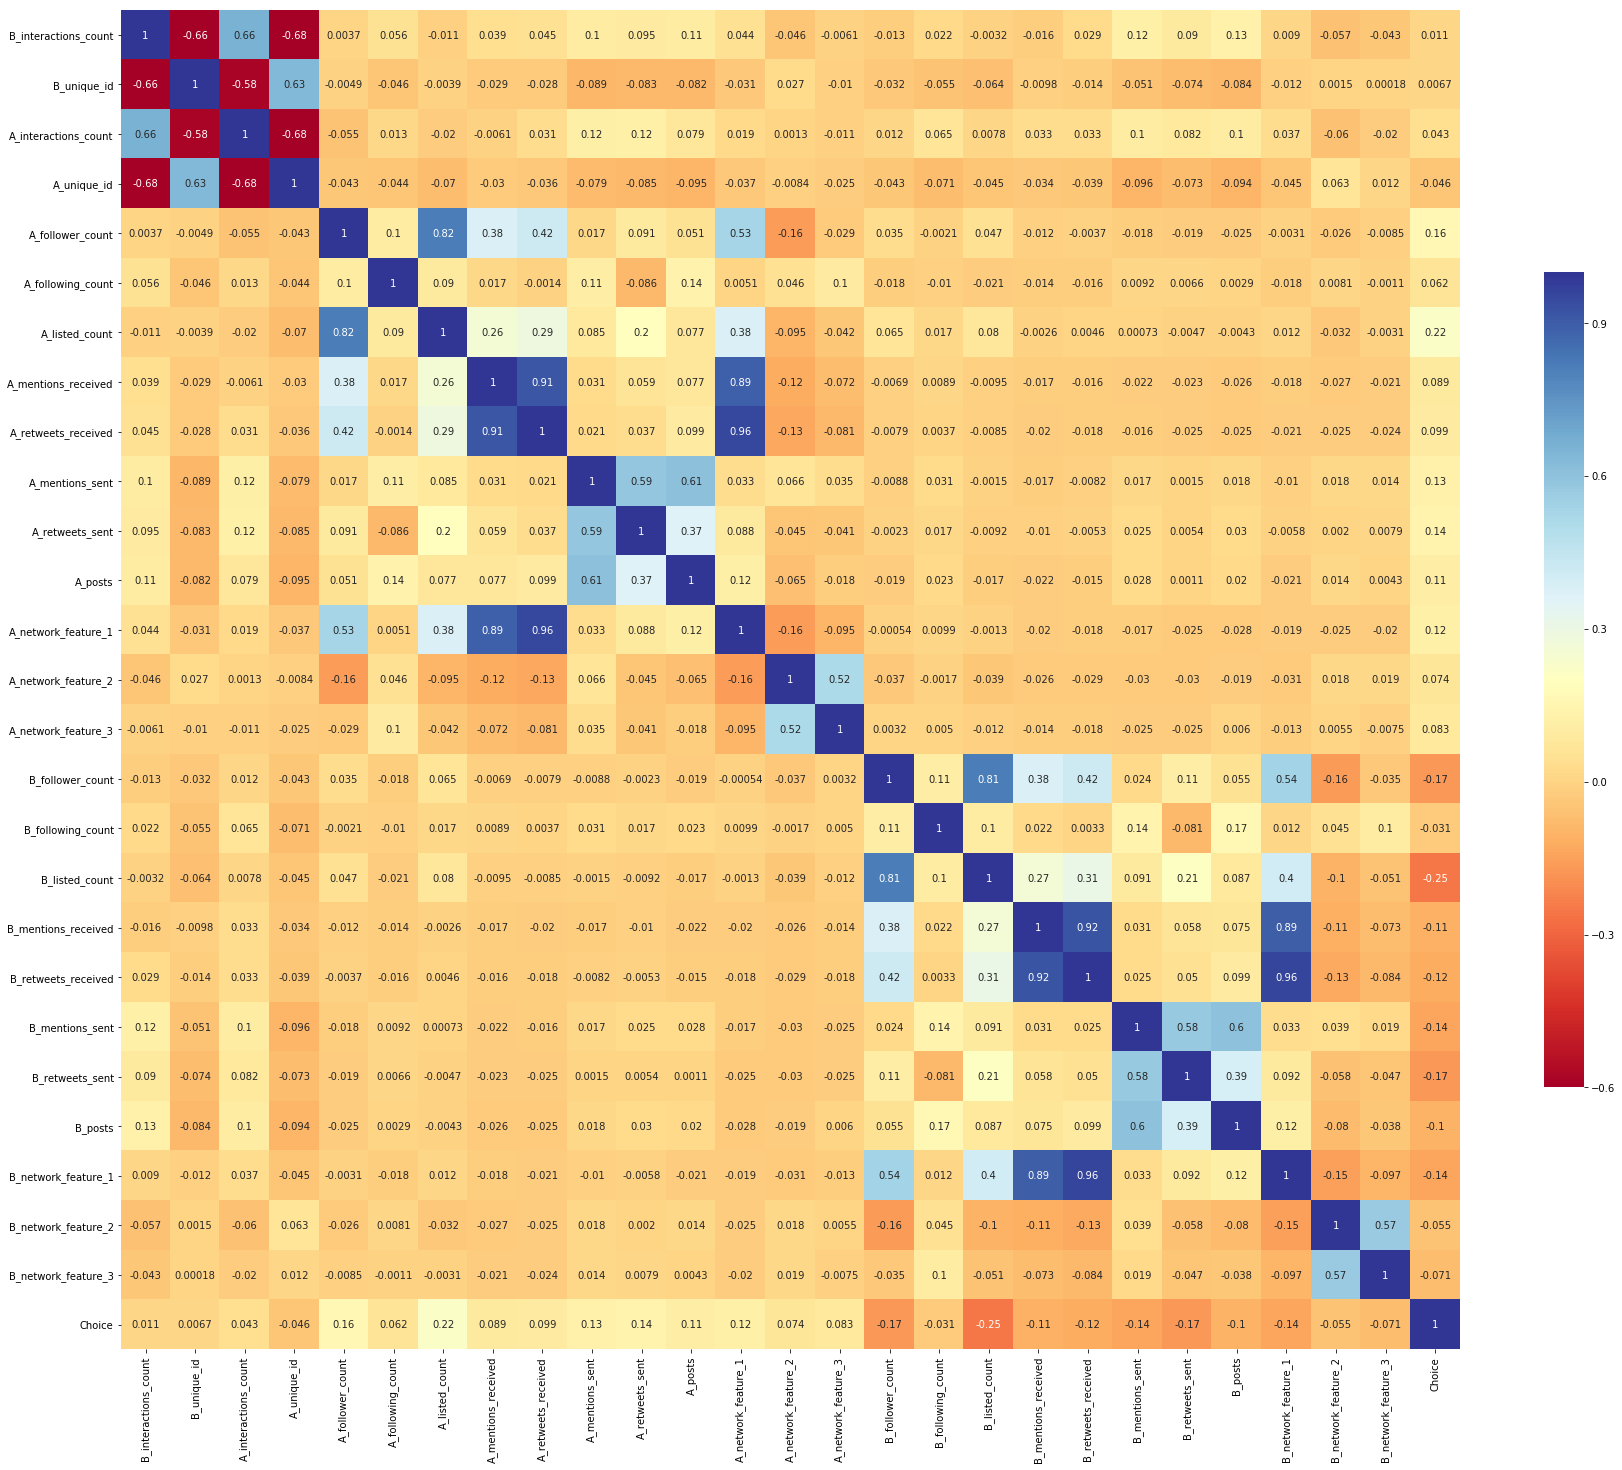

In [25]:
corr = train_df.corr()
plt.subplots(figsize=(30, 30))
cmap = sns.diverging_palette(150, 250, as_cmap=True)
sns.heatmap(corr, cmap="RdYlBu", vmax=1, vmin=-0.6, center=0.2, square=True, linewidths=0, cbar_kws={"shrink": .5}, annot = True);

There are three ares at the plot that have a certain pattern:
* upper-left corner shows highly correlated among themselves features that were added before: unique IDs and number of interactions of the users. This was expected by their construction
* two big ractangles represent the correlations of the features between the features of each user A and B. One can think of dropping the most correlated of them, i.e. network_feature_1 vs retweets_received vs mentions_received for both users
* the dedicated feature importance analysis is needed to determine the most sensitive features and drop others


# Baseline 

Simple XGBoost/RF/LR models to evaluate the performance and have a baseline

## Base model functions and evaluation 
Function to perform the classification and evaluate the results

In [26]:
def evaluate_model(model, x_train, y_train, x_test, y_test):
    # Train the algorithm
    model.fit(x_train,y_train)
    #predict the output
    predictions = model.predict(x_test)
    predicting_prob = model.predict_proba(x_test)[:,1]
    
    print(model)
    # Evaluate the results
    #Accuracy score 
    accuracy = accuracy_score(y_pred=predictions,y_true=y_test)
    print("\nAccuracy: {:.3f}% \n".format(accuracy*100))
    # ROC AUC score
    roc_auc = roc_auc_score(y_score=predicting_prob,y_true=y_test)
    print("ROC AUC: {:.3f}% \n".format(roc_auc*100))
    
    print('\n\n')
    return model

# Useful functions for fast evaluation of the results during the feature engineering
def fast_model_evaluation(x_train,y_train,models,names):
    model_res={}
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=1)
    for model,name in zip(models,names):
        model_res[name] = evaluate_model(model,x_train,y_train,x_test,y_test)
    return model_res

def faster_model_evaluation(df,models,names,label='Choice'):
    y_train = df[label]
    x_train = df.drop(columns=[label])
    model_res = fast_model_evaluation(x_train,y_train,models,names)
    return model_res

Feature importance can also be evaluated from the models

In [27]:
# function to evaluate the feature importance
def feature_importance(df_ini,model,model_type):
    # transform the input data, accessing is different for different algorithms, hard coded now. 
    # Should be imporved later
    if model_type == 'importance':
        df = pd.DataFrame(model.feature_importances_,df_ini.columns).reset_index()
    else:
        df = pd.DataFrame(model.coef_.ravel(),df_ini.columns).reset_index()
    df.rename(columns={'index':'features',0:'coefficients'},inplace=True)
    # sort the values
    df.sort_values(by='coefficients',ascending = False,inplace=True)
        
    #plot
    sns.barplot(x = df['coefficients'] ,y = df['features'])    
    plt.title("Feature Importance",fontsize=18,fontweight="bold")

### Initial evaluation 

* Done without models tunning and with very-very original features
* As initial models the XGBoost, LogisticRegression and RandomForest algorithms are used

In [28]:
names = [
        'XGBoost',
        'LogisticRegression',
        'RandomForest',
]

# Define set of models
models = [XGBClassifier(random_state=1,n_estimators=100),
          LogisticRegression(random_state=1,penalty='l1'),
         RandomForestClassifier(n_estimators=100,random_state=1,max_depth=3,min_samples_leaf=10)]

In [29]:
model_res = faster_model_evaluation(pure_train_df,models,names)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Accuracy: 76.364% 

ROC AUC: 85.989% 




LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Accuracy: 69.909% 

ROC AUC: 77.270% 




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
    

Without any tunning of the models and any feature engineering quite high scores can be achieved, using advanced algorithms like XGBoost (85.989%) or RF (84.083%), while simple LR gives only 77.27%. 

LR scores can definetely be improved by:
* feature transformation
* feature scaling and normalisation
* drop of the outliers
* etc

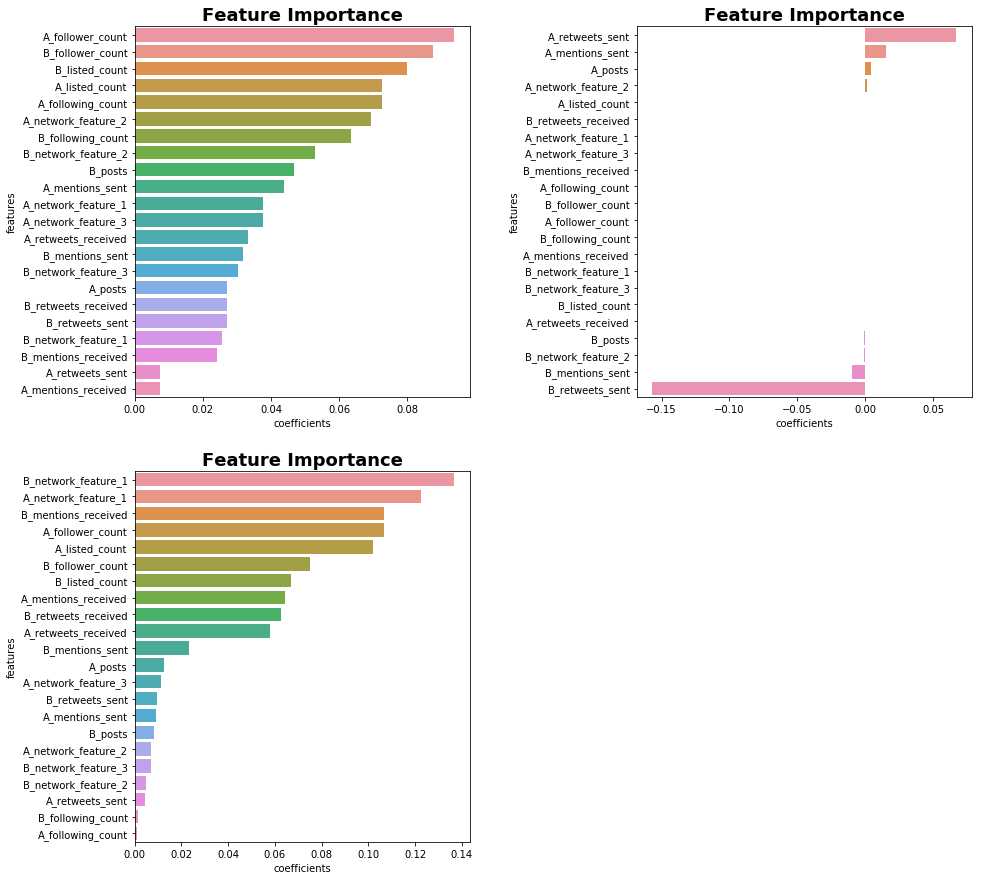

In [30]:
def fast_feature_importance(df):
    df_x = df
    # Analyse feature importance
    plt.figure(figsize=(15,15))
    plt.subplots_adjust(wspace=0.5)
    for i, model in enumerate(models,start=1):
        model_type = 'importance'
        #for LR
        if i == 2: 
            model_type = 'coef'
        plt.subplot(2,2,i)
        # provide only x-values:
        if 'Choice' in df.columns:
            df_x = df.drop(columns=['Choice'])
        feature_importance(df_x,model,model_type)

fast_feature_importance(pure_train_df)  

Model 1:
* As expected, the follower_count and listed_count features are the most important (and they are highly correlated > 82%). 
* Second place, in the original features, is taken by following_count and network_feature_2. As for the first of them, such an importance was expected as well, the second 'misterious' network_feature_2 shows a strong influence on the same level.

Model 2:
* The most important features are retweets_sent and mentions_sent, this is probably because these features have much less prominent outliers and much smaller valrience.
* Picture will most-likely change after the feature engineering

Model 3:
* Here, the most important features are network_feature_1, followed by follower_count and mentions_received only for the B-user. This is very interesting and should be further investigated.

# Feature engineering

In [31]:
# Separate labels and features
y_train = train_df.Choice
x_train = train_df.drop(columns=['Choice'])

* Evaluate the models again with the training dataset with additional columns added before and outliers deduction

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Accuracy: 78.008% 

ROC AUC: 87.492% 




LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Accuracy: 72.744% 

ROC AUC: 79.101% 




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
    

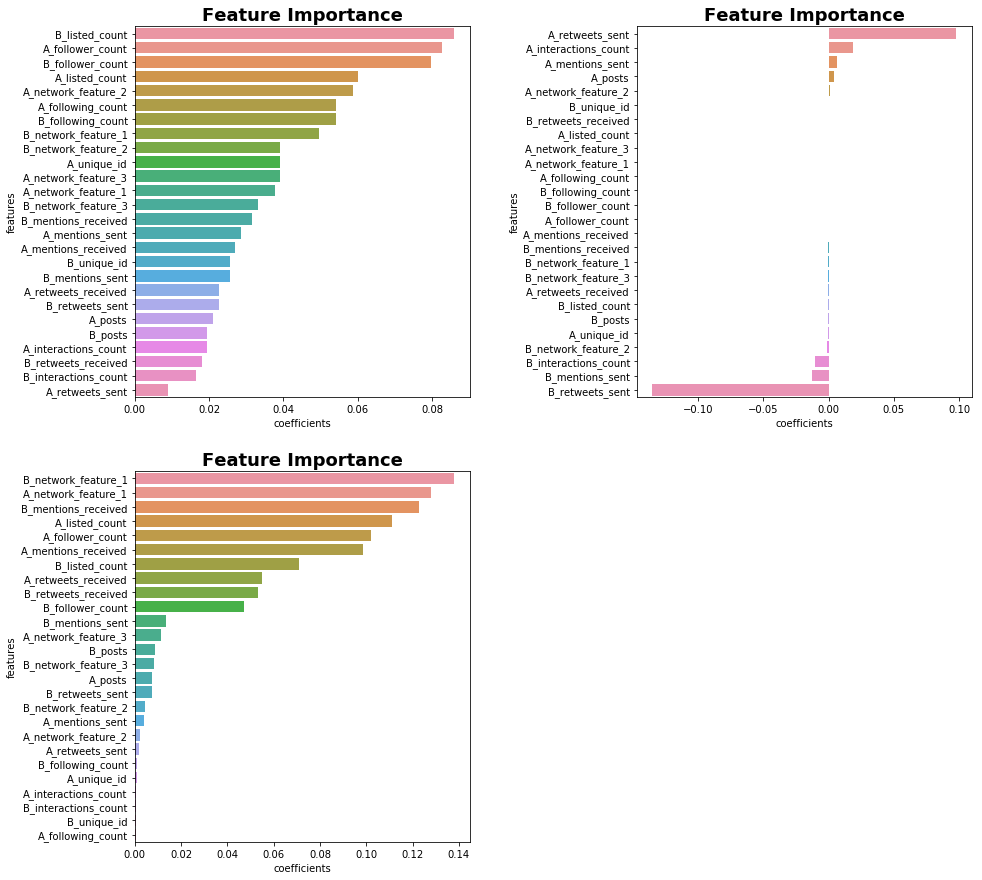

In [32]:
faster_model_evaluation(train_df,models,names)
fast_feature_importance(train_df)

* Additional information, introduced in the previous sections helped to acheive better performance of all models

In [33]:
#get stats
def get_stats(col):
    mean=col.mean()
    mode=col.mode().get_values()[0]
    vmin = col.min()
    vmax = col.max() 
    return mean,mode,vmin,vmax 

# Function to plot the distributions of the features
def plot_features(df_null,df_new):
    
    for i, col in enumerate(df_new.columns,start=1):
        plt.figure(i,figsize=(14, 5))
    
        # compute stats for the distributions
        ini_mean,ini_mode,ini_vmin,ini_vmax = get_stats(df_null[col])
        new_mean,new_mode,new_vmin,new_vmax = get_stats(df_new[col])    
    
        # distribution of each feature form the initial DF
        plt.subplot(1, 3, 1)
        sns.distplot(df_null[col],kde=False)
        plt.axvline(ini_mean, color='r', linestyle='--')
        plt.axvline(ini_mode, color='g', linestyle='-')
        plt.legend({'Mean {:0.3f}'.format(ini_mean):ini_mean,
                'Mode {:0.3f} \n Min {:0.3f} \n Max {:0.3f}'.format(ini_mode,ini_vmin,ini_vmax):ini_mode})
    

        # distribution of each feature after the transformation
        plt.subplot(1, 3, 2)
        sns.distplot(df_new[col],kde=False)
        plt.axvline(new_mean, color='r', linestyle='--')
        plt.axvline(new_mode, color='b', linestyle='-')
        plt.legend({'Mean {:0.3f}'.format(new_mean):new_mean,
                    'Mode {:0.3f} \n Min {:0.3f} \n Max {:0.3f}'.format(new_mode,new_vmin,new_vmax):new_mode})
    
        # Add log-y plot to better see the low populated regions
        plt.subplot(1, 3, 3)
        ax = sns.distplot(df_new[col],kde=False)
        ax.set_yscale('log')
        plt.axvline(new_mean, color='r', linestyle='--')
        plt.axvline(new_mode, color='b', linestyle='-')
        plt.legend({'Mean {:0.3f}'.format(new_mean):new_mean,
                    'Mode {:0.3f} \n Min {:0.3f} \n Max {:0.3f}'.format(new_mode,new_vmin,new_vmax):new_mode})

## Data scaling and normalisation

* Expected to imporve performance of the LR

### StandardScaler

Remove the mean and scaling to unit variance

In [34]:
# function to perform the data scaling
def StandardScaling(x_df,except_col):
    stsc = preprocessing.StandardScaler()
    cols = [x for x in x_df.columns if x not in except_col]
    model = stsc.fit(x_df[cols])
    x_df[cols] = stsc.transform(x_df[cols])
    return model

In [45]:
x_train_t = x_train.copy()
stsc = StandardScaling(x_train_t,['A_unique_id','B_unique_id'])
path = 'lib/models/StandardScaler.pkl'
with open(path, 'wb') as f:
            pickle.dump(stsc, f)
            print("Pickled classifier at {}".format(path))
x_train_t.describe()

Pickled classifier at lib/models/StandardScaler.pkl


,B_interactions_count,B_unique_id,A_interactions_count,A_unique_id,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,...,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
count,5.319000e+03,5319.000000,5.319000e+03,5319.000000,5.319000e+03,5.319000e+03,5.319000e+03,5.319000e+03,5.319000e+03,5.319000e+03,...,5.319000e+03,5.319000e+03,5.319000e+03,5.319000e+03,5.319000e+03,5.319000e+03,5.319000e+03,5.319000e+03,5.319000e+03,5.319000e+03
mean,-1.089559e-17,184.426396,1.587218e-16,227.515134,6.110506e-17,-1.316550e-17,-2.587181e-17,1.481967e-18,-1.452745e-17,-2.669628e-17,...,-1.043639e-20,-6.443426e-17,-2.424373e-17,-5.733752e-17,-1.555492e-16,5.975635e-16,-8.169605e-17,4.670284e-18,4.417723e-17,2.087278e-19
std,1.000094e+00,153.163876,1.000094e+00,247.164414,1.000094e+00,1.000094e+00,1.000094e+00,1.000094e+00,1.000094e+00,1.000094e+00,...,1.000094e+00,1.000094e+00,1.000094e+00,1.000094e+00,1.000094e+00,1.000094e+00,1.000094e+00,1.000094e+00,1.000094e+00,1.000094e+00
min,-2.282768e+00,0.000000,-2.291426e+00,0.000000,-3.418412e-01,-2.563555e-01,-4.927551e-01,-1.829679e-01,-1.970383e-01,-6.163998e-01,...,-2.560063e-01,-5.016895e-01,-1.785873e-01,-1.973326e-01,-6.153626e-01,-5.225733e-01,-4.880462e-01,-2.457704e-01,-8.012067e-01,-6.750811e-01
25%,-2.695183e-01,73.000000,-2.750428e-01,76.000000,-3.403252e-01,-2.497957e-01,-4.849988e-01,-1.826038e-01,-1.968585e-01,-5.895295e-01,...,-2.492372e-01,-4.947051e-01,-1.782526e-01,-1.971583e-01,-5.888788e-01,-5.225733e-01,-4.498390e-01,-2.451298e-01,-6.498939e-01,-4.587039e-01
50%,1.331316e-01,153.000000,1.282337e-01,162.000000,-3.165155e-01,-2.405342e-01,-4.115428e-01,-1.777087e-01,-1.930440e-01,-3.910248e-01,...,-2.400010e-01,-4.194594e-01,-1.735073e-01,-1.934800e-01,-3.932293e-01,-3.950601e-01,-3.164769e-01,-2.348221e-01,-2.853582e-01,-2.748650e-01
75%,5.357815e-01,245.000000,6.659358e-01,258.000000,-1.366168e-01,-1.982691e-01,1.177965e-01,-1.453458e-01,-1.659424e-01,1.117675e-01,...,-1.968776e-01,1.211361e-01,-1.419012e-01,-1.686101e-01,8.161071e-02,1.205231e-01,4.722059e-02,-1.735291e-01,2.524768e-01,1.123023e-01
max,2.414814e+00,787.000000,2.413467e+00,1171.000000,2.003705e+01,2.360512e+01,2.168758e+01,1.867288e+01,1.507713e+01,7.421324e+00,...,1.135766e+01,2.213469e+01,1.820813e+01,1.478182e+01,7.306747e+00,8.028214e+00,9.722628e+00,1.220022e+01,1.668247e+01,1.286999e+01


In [36]:
# Evaluate the performance
fast_model_evaluation(models=models,x_train=x_train_t,y_train=y_train,names=names)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Accuracy: 78.008% 

ROC AUC: 87.492% 




LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Accuracy: 72.838% 

ROC AUC: 79.110% 




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
    

{'XGBoost': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
        max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
        n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
        silent=True, subsample=1),
 'LogisticRegression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l1', random_state=1, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
 'RandomForest': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=3, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=10, min_samples_split=2,
             min_weight_f

* Minor imporvement for the Logistic regression. Proceed with feature engineering
* Other features are not affected, as expected

### Gaussian shape 

In [37]:
# function to perform the data normalisation
def QuantileTransform(x_df,except_col):
    qt = preprocessing.QuantileTransformer(output_distribution='normal', random_state=1)
    cols = [x for x in x_df.columns if x not in except_col]
    model = qt.fit(x_df[cols])
    x_df[cols] = qt.transform(x_df[cols])
    return model

In [ ]:
#Apply transformations
qtm = QuantileTransform(x_train_t,['A_unique_id','B_unique_id','A_interactions_count','B_interactions_count'])
# Save the model
path = 'lib/models/QuantileTransform.pkl'
with open(path, 'wb') as f:
            pickle.dump(qtm, f)
            print("Pickled classifier at {}".format(path))

In [ ]:
# and plot the distributions
plot_features(x_train,df_new=x_train_t)

* Normal shape for most of the features has been achieved

In [39]:
# Evaluate the performance
fast_model_evaluation(models=models,x_train=x_train_t,y_train=y_train,names=names)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Accuracy: 77.726% 

ROC AUC: 87.581% 




LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Accuracy: 75.564% 

ROC AUC: 85.558% 




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
    

{'XGBoost': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
        max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
        n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
        silent=True, subsample=1),
 'LogisticRegression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l1', random_state=1, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
 'RandomForest': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=3, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=10, min_samples_split=2,
             min_weight_f

* Significant improvement of the LR by 4% due to the feature transformation

## Check possible derived features

In [40]:
x_train_t2 = x_train_t.copy()

In [41]:
# Create a bunch of "A-B" and "A/B" features
minus_features = ['follower_count']
ratio_features = ['interactions_count']
for col in minus_features:
    x_train_t2['AmB_' + col] = x_train_t2['A_'+col] - x_train_t2['B_'+col]
    
for cand in ['A','B']:
    x_train_t2[cand + '_follower_m_following_count'] = x_train_t2[cand + '_follower_count'] - x_train_t2[cand + '_following_count']
    x_train_t2[cand + '_received_m_send_mentions'] = x_train_t2[cand + '_mentions_received'] - x_train_t2[cand + '_mentions_sent']
    

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Accuracy: 79.135% 

ROC AUC: 87.821% 




LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Accuracy: 75.564% 

ROC AUC: 85.546% 




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
    

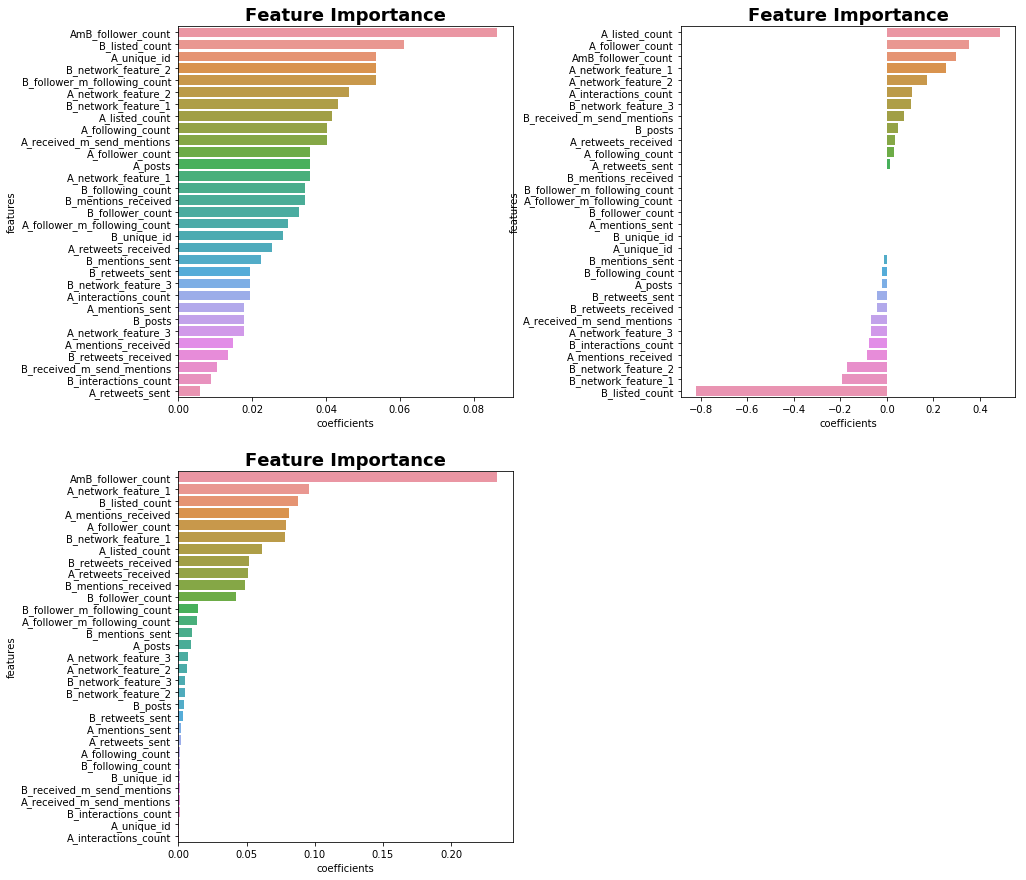

In [42]:
# Evaluate the performance
fast_model_evaluation(models=models,x_train=x_train_t2,y_train=y_train,names=names)
fast_feature_importance(x_train_t2)

* Small improvement in the performance is observed. Probably more complex analysis is needed, which can not done in a given timescale

In [43]:
x_train_t = x_train_t2

## Clustering the data

* From the patterns observed during the network analysis, it seems to be a good idea to try the clusterisation algorithms and add the result as additional feature

In [43]:
# Define the clustering algorithm to be probed
n_clusters = 10
cluster_algo = KMeans(n_clusters=n_clusters, random_state=1)

In [44]:
# prepare the data for clustering
x_cluster = x_train_t.drop(columns=['B_unique_id','A_unique_id'])
cluster_model = cluster_algo.fit(x_cluster)
y_cluster = cluster_model.predict(x_cluster)

In [45]:
# Add obtained values as a separate column
x_train_t3 = x_train_t.copy()
x_train_t3['Cluster'] = y_cluster
# And perform one hot encoding 
x_train_t3 = pd.get_dummies(columns=['Cluster'],data=x_train_t3)
x_train_t3.head()

,B_interactions_count,B_unique_id,A_interactions_count,A_unique_id,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,...,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9
0,-0.135302,0,-0.140617,190,-1.615945,-0.726606,-1.798663,-1.164444,-5.199338,-5.199338,...,0,0,1,0,0,0,0,0,0,0
1,-0.269518,1,-0.140617,113,-0.147316,0.280911,-0.337506,0.198258,0.221344,0.523537,...,0,0,0,0,0,1,0,0,0,0
2,-2.148551,2,-2.291426,788,-0.346053,0.284511,-0.641053,-0.146337,-0.087693,0.485973,...,0,1,0,0,0,0,0,0,0,0
3,0.535781,3,0.128234,99,-2.877846,-1.976943,-1.985876,-0.466803,-1.086456,-0.253606,...,0,0,0,0,0,0,0,0,1,0
4,0.401565,4,0.531510,307,0.012546,0.072829,0.275694,0.385726,0.313694,1.792374,...,0,0,0,1,0,0,0,0,0,0


* Evaluate the performance

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Accuracy: 79.135% 

ROC AUC: 87.816% 




LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Accuracy: 75.470% 

ROC AUC: 85.443% 




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
    

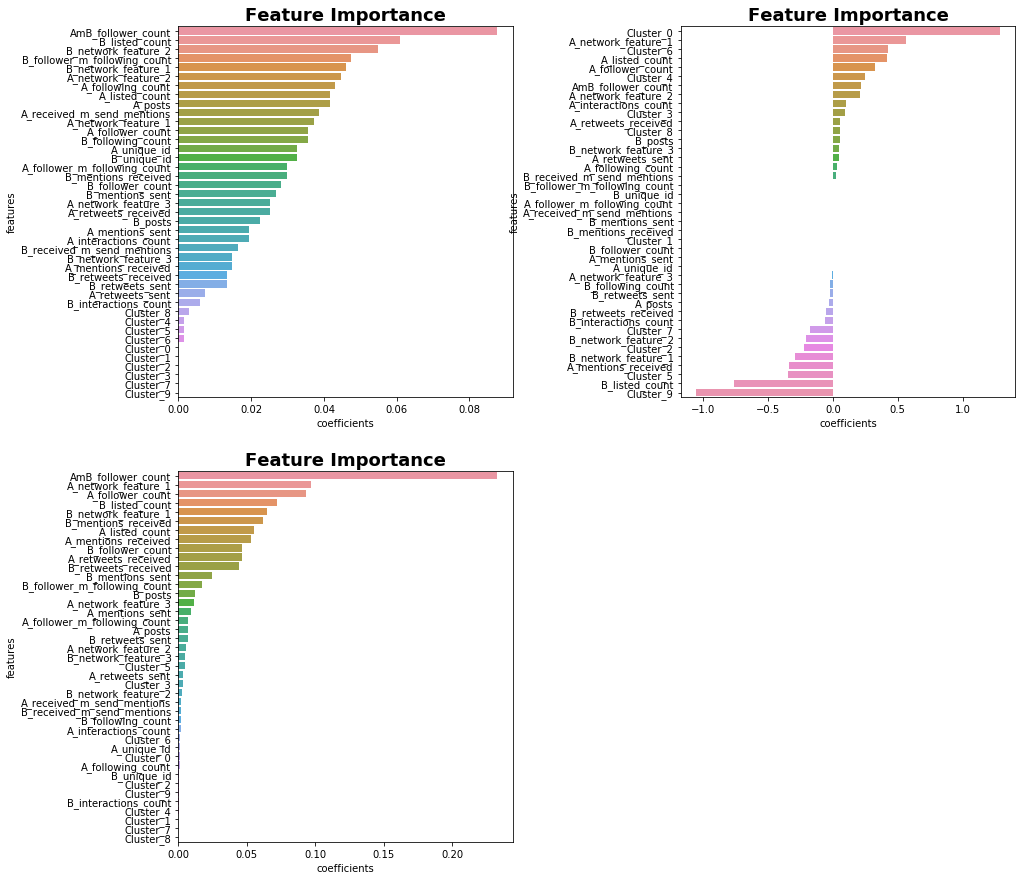

In [46]:
fast_model_evaluation(models=models,x_train=x_train_t3,y_train=y_train,names=names)
fast_feature_importance(x_train_t3)

* No improvement, even a small degradation of the performance. However, keep the clusters for the time being

# Model tunning

## More elaborative evaluation

In [47]:
# Function to evaluate the results using Accuracy and ROC AUC
def evaluate(model,x_test,y_true):
    #predict the output
    predictions = model.predict(x_test)
    predicting_prob = model.predict_proba(x_test)[:,1]
    
    #Accuracy score 
    accuracy = accuracy_score(y_pred=predictions,y_true=y_true)
    print("\nAccuracy: {:.3f}% ".format(accuracy*100))
    # ROC AUC score
    roc_auc = roc_auc_score(y_score=predicting_prob,y_true=y_true)
    print("ROC AUC: {:.3f}% \n".format(roc_auc*100))  

# Run cross-validation
def run_cross_validation(model,x_tot,y_tot,cv):
    print('Starting Cross-validation')
    
    #Score using accuracy
    scoresAccuracy=cross_val_score(model,x_tot,y_tot,cv=cv,verbose=1)
    print("CV with accuracy: %0.3f +/- %0.3f" % (scoresAccuracy.mean(), scoresAccuracy.std()))
    
    #Score with AUC
    scoresROCAUC=cross_val_score(model,x_tot,y_tot,cv=cv,scoring='roc_auc',verbose=1)
    print("CV with ROC AUC: %0.3f +/- %0.3f" % (scoresROCAUC.mean(), scoresROCAUC.std()))
    
    #Plot learning curve 
    plot_learning_curve(model,name,x_tot,y_tot,cv=cv,n_jobs=-1)
    plt.show()
    
def advanced_evaluate_model(model,name, x_train, y_train, x_test, y_test, cv):
    # Train the algorithm
    history = model.fit(x_train,y_train)
    #predict the output
    predictions = model.predict(x_test)
    predicting_prob = model.predict_proba(x_test)[:,1]
    
    print(model)
    # Evaluate the results
    evaluate(model,x_test,y_test) 
    
    # Merge test and train samples
    x_tot = pd.concat([x_train,x_test],axis=0)
    y_tot = pd.concat([y_train,y_test],axis=0)

    # If run cross-validation:
    if cv:
        #Cross-validation

        # Splitting strategy
        kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)
    
        run_cross_validation(model,x_tot,y_tot,cv=kfold)
    
    # ROC Curve. 
    fpr,tpr,thresh = roc_curve(y_test,predicting_prob)
    plt.figure(figsize=(7,7))
    plt.plot(fpr,tpr,label = ("Area under the curve {:0.3f}".format(auc(fpr,tpr))),color = "r")
    plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
    plt.legend(loc = "best")
    plt.title(name + " ROC - Curve & Area Under Curve",fontsize=18)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.show()
    
    # plot learning history:
    if name == 'DNN': 
        plot_DNN_training_history(history)
        plt.show()
    
    print('\n\n')
    
    model.fit(x_tot,y_tot)
    
    return model

In [48]:
# function from 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [49]:
def plot_DNN_training_history(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'])
    plt.show()
    return plt

## DNN

In [50]:
# baseline model
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(60, input_dim=36, kernel_initializer='normal', activation='relu'))
    model.add(Dense(40, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [51]:
models_tuned = [
    XGBClassifier(random_state=1,n_estimators=1000,learning_rate=0.01,max_depth=3),
    LogisticRegression(penalty='l1',class_weight='balanced', random_state=1),
    RandomForestClassifier(n_estimators=100,random_state=1,max_depth=3,min_samples_leaf=10),
]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Accuracy: 79.229% 
ROC AUC: 87.975% 



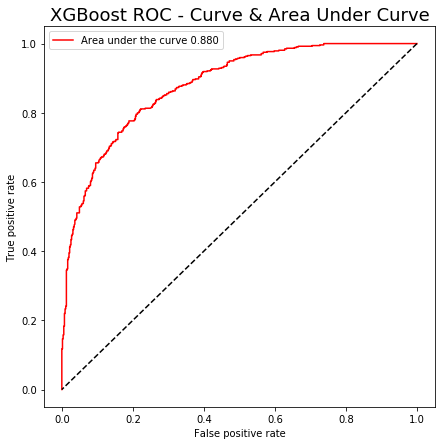




LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

Accuracy: 75.188% 
ROC AUC: 85.433% 



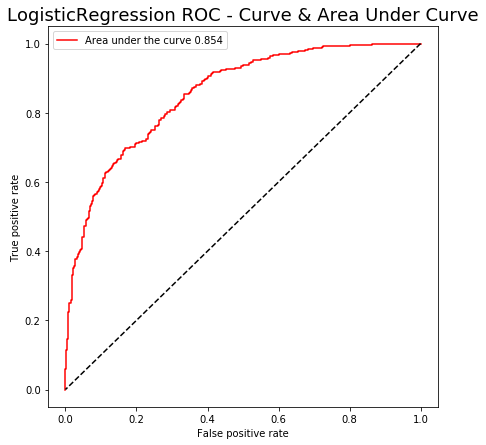




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

Accuracy: 76.880% 
ROC AUC: 86.307% 



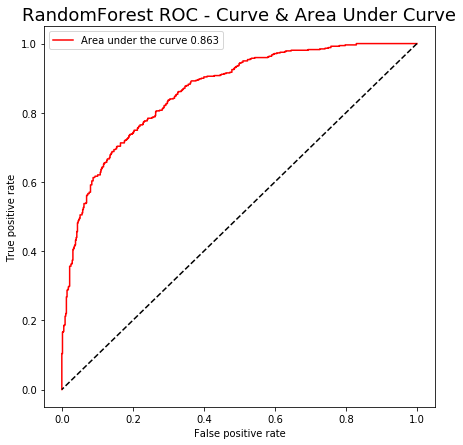

In [52]:
model_res = {}
x_train_t, x_test_t, y_train_t, y_test_t = train_test_split(x_train_t3, y_train, test_size=0.2, random_state=1)
for model, name in zip(models_tuned,names):
    model_res[name] = advanced_evaluate_model(model,name,x_train_t,y_train_t,x_test_t,y_test_t,False)

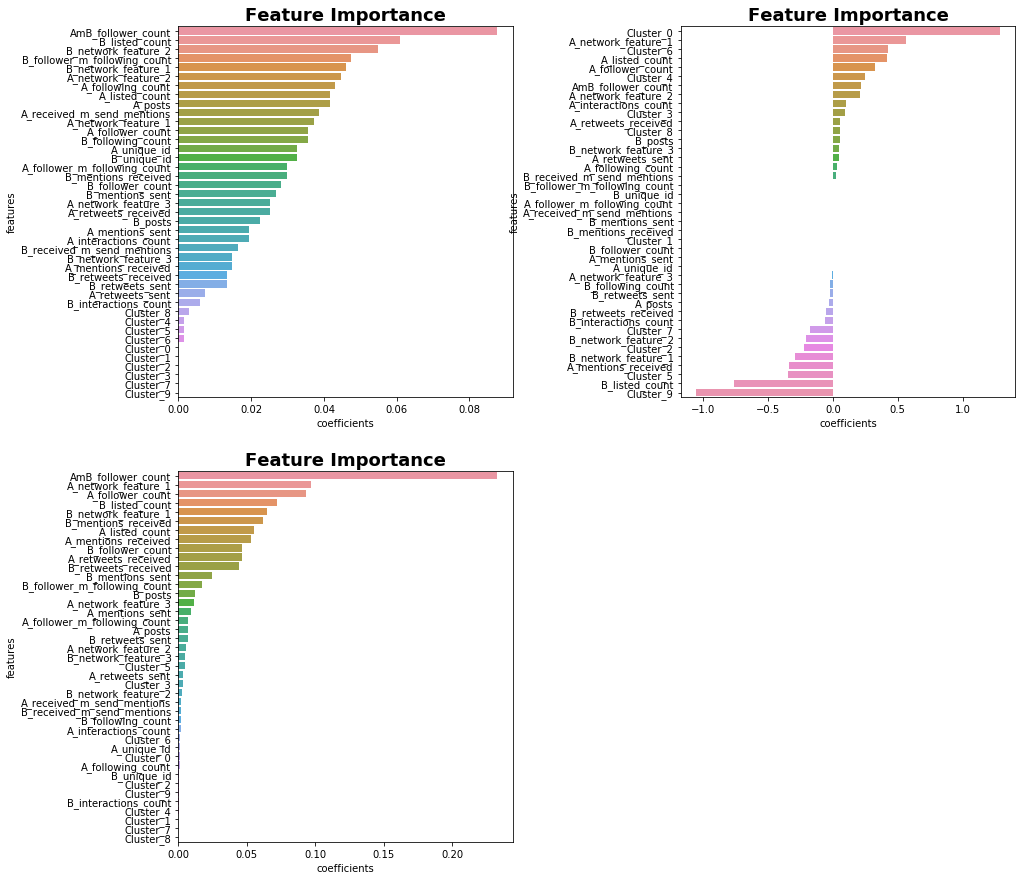

In [53]:
fast_feature_importance(x_train_t3)

* The distribution of the feature importance has been significantly changed by the feature engineering. Derived and introduced features play more important role than the original features. 

## RandomForest tunning

using the RandomizedSearchCV and GridSearchCV

* The RF tunning was done at the multi-core servers and results can not be reproduced here
* Unfortunately, the BGBoost and LR was not tuned properly due to luck of time
* Also the performance of a DNN was not tuned and therefore not used in the final results.

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=1, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train_t, y_train_t)

In [ ]:
def evaluate(model, x_test, y_test):
    predicting_prob = model.predict_proba(x_test)[:,1]
    roc_auc = roc_auc_score(y_score=predicting_prob,y_true=y_test)
    print("BASE ROC AUC: {:.3f}% \n".format(roc_auc*100)) 
    
    return roc_auc

In [ ]:
# ROC AUC score
predicting_prob = model.predict_proba(x_test)[:,1]
roc_auc = roc_auc_score(y_score=predicting_prob,y_true=y_test)
print("ROC AUC: {:.3f}% \n".format(roc_auc*100)) 

In [ ]:
base_model = RandomForestClassifier(n_estimators = 10, random_state = 1)
base_model.fit(x_train_t, y_train_t)
base_predicting_prob = base_model.predict_proba(x_test_t)[:,1]
base_roc_auc = roc_auc_score(y_score=base_predicting_prob,y_true=y_test_t)
print("BASE ROC AUC: {:.3f}% \n".format(base_roc_auc*100)) 

best_random = rf_random.best_estimator_
random_predicting_prob = best_random.predict_proba(x_test_t)[:,1]
random_roc_auc = roc_auc_score(y_score=random_predicting_prob,y_true=y_test_t)
print("RAND ROC AUC: {:.3f}% \n".format(random_roc_auc*100)) 

In [ ]:
rf_random.best_params_

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 14, 18, 19, 20,21, 22, 25, 29],
    'max_features': [2, 3],
    'min_samples_leaf': [1,2,3, 4],
    'min_samples_split': [3,4,5,6,7],
    'n_estimators': [450,500,550,575,600,625,650,675,700]
}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [176]:
grid_search.fit(x_train_t, y_train_t)
grid_search.best_params_

Fitting 3 folds for each of 3240 candidates, totalling 9720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 33.4min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 43.3min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 55.4min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 70.5min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 88.9min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 109.7min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 132.4min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 156.9min
[Parallel(n_jobs=-1)]: Done 9105 tasks     

{'bootstrap': True,
 'max_depth': 20,
 'max_features': 2,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 450}

In [178]:
best_random = grid_search.best_estimator_
grid_search_predicting_prob = grid_search.predict_proba(x_test_t)[:,1]
grid_search_roc_auc = roc_auc_score(y_score=grid_search_predicting_prob,y_true=y_test_t)
print("GRID SEARCH ROC AUC: {:.3f}% \n".format(grid_search_roc_auc*100)) 

GRID SEARCH ROC AUC: 87.447% 



## XGBoost

In [190]:
# which booster to use
booster = ['gbtree','dart']
# eta - learning_rate
learning_rate = [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 20, num = 10)]
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'learning_rate' : learning_rate,
               'booster': booster}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20], 'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35], 'booster': ['gbtree', 'dart']}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
xgb = XGBClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = random_grid, n_iter = 250, cv = 2, verbose=2, random_state=1, n_jobs = -1)
# Fit the random search model
xgb_random.fit(x_train_t, y_train_t)

Fitting 2 folds for each of 250 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 11.8min


In [193]:
baseline_set = models_tuned[0].fit(x_train_t, y_train_t)

In [196]:
print('BEST RANDOM:')
evaluate(xgb_random,x_test_t,y_test_t)
print('BASELINE')
evaluate(baseline_set,x_test_t,y_test_t)

BEST RANDOM:
BASE ROC AUC: 85.684% 

BASELINE
BASE ROC AUC: 87.778% 



0.8777834204419617

In [400]:
xgb_random.best_params_

NameError: name 'xgb_random' is not defined

## Evaluate performance

In [471]:
names = [
        'XGBoost',
        'LogisticRegression',
        'RandomForest',
#        'DNN'
]
models_tuned = [
    XGBClassifier(random_state=1,n_estimators=1000,learning_rate=0.01,max_depth=3),
    LogisticRegression(penalty='l1',class_weight='balanced', random_state=1),
    RandomForestClassifier(n_jobs=16,n_estimators=450, random_state=1,
                          criterion='entropy',max_depth=20,
                          max_features=2,
                          min_samples_leaf=2,
                          min_samples_split=5,
                          bootstrap=True),
 #   KerasClassifier(build_fn=create_baseline, epochs=30, batch_size=5, verbose=0)
]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Accuracy: 79.229% 
ROC AUC: 87.975% 

Starting Cross-validation


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CV with accuracy: 0.782 +/- 0.016
CV with ROC AUC: 0.872 +/- 0.016


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.3min finished


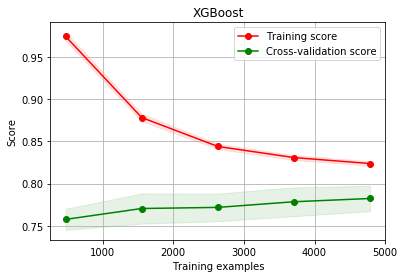

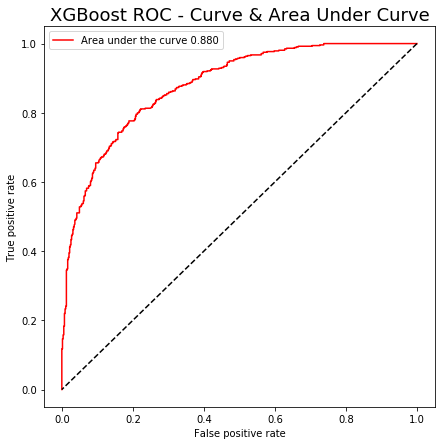




LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

Accuracy: 75.188% 
ROC AUC: 85.433% 

Starting Cross-validation


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CV with accuracy: 0.770 +/- 0.018


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.5s finished


CV with ROC AUC: 0.857 +/- 0.015


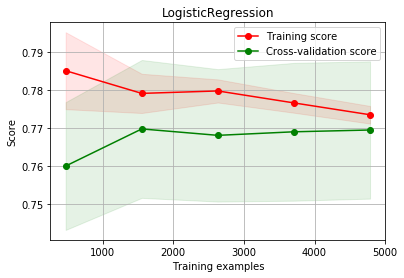

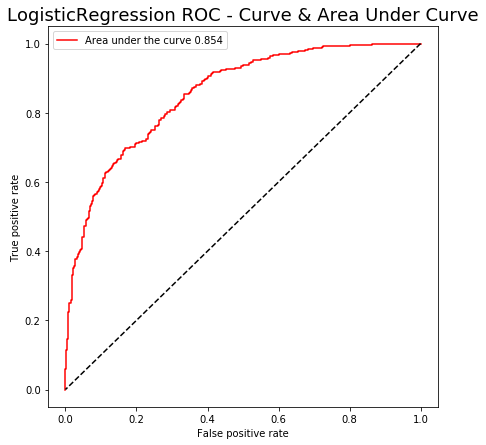




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=450, n_jobs=16,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

Accuracy: 78.008% 
ROC AUC: 87.238% 

Starting Cross-validation


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   41.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CV with accuracy: 0.774 +/- 0.017


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   41.8s finished


CV with ROC AUC: 0.866 +/- 0.016


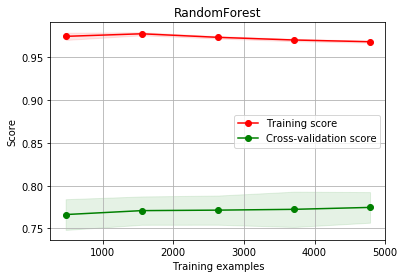

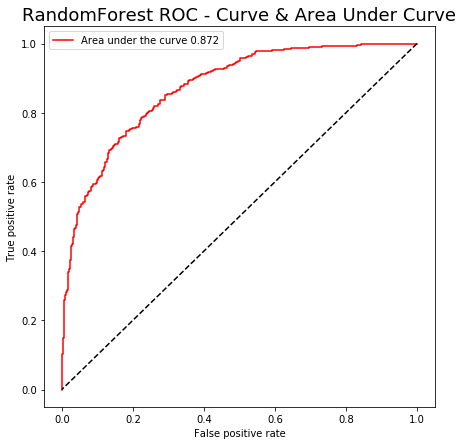

In [472]:
model_res = {}
x_train_t, x_test_t, y_train_t, y_test_t = train_test_split(x_train_t3, y_train, test_size=0.2, random_state=1)
for model, name in zip(models_tuned,names):
    model_res[name] = advanced_evaluate_model(model,name,x_train_t,y_train_t,x_test_t,y_test_t,True)

* As RF was intensively tuned, the performance of this algorithm has improved by 1% (ROC AUC  without CV).
* Cross-validation scores for XGBoost and RF are lower than obtained from a simple training dataset splitting, but within the uncertainty. Even though the LR shows better scores at the CV it also covered by the uncertainty.

## Save the models

In [ ]:
for model, name in zip(models_tuned,names):
    path = 'lib/models/Model_' + name + '.pkl'
    with open(path, 'wb') as f:
            pickle.dump(model, f)
            print("Pickled classifier at {}".format(path))

# Results predictions

## Load the test dataset 

In [54]:
#load the data
test_df = pd.read_csv("lib/data/test.csv",sep=",")
print(test_df.shape)
test_df.head()

(5952, 22)


,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,A_network_feature_2,...,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
0,614689,400,5729,199.618296,67.812469,9.366192,0.359534,4.094488,669,39.193741,...,563,20057,967.720642,579.431128,4.473798,0.805680,6.241806,4027,57.643839,3201.293706
1,739581,10723,1279,102.026750,96.771319,1.537322,1.054358,3.467754,432,11.191686,...,12949,1311,38.260522,10.697567,12.845793,1.584284,12.106662,144,209.717241,21496.565517
2,3638,3341,85,2.793577,1.402703,2.594089,0.598150,3.802143,11,9.416667,...,320,3673,1207.190077,599.721600,0.842022,0.593199,7.044735,3918,7.859818,637.983300
3,613,1259,31,1.326041,0.356943,6.249678,2.323064,7.488116,4,5.000000,...,3599,1072,10.300222,3.828561,1.624092,0.100503,1.614287,43,113.840909,2537.772727
4,1352348,331,15647,19129.848662,14552.733991,2.065418,0.580955,16.281502,52580,3.092448,...,147521,15043,9902.070379,5012.055876,10.438460,0.100503,193.072418,28564,10.964144,1035.955493


## Prepare the features 

### Add unique_id

In [55]:
# Adding the features as done with the training dataset
# Split the dataset into A and B
A_test_df = test_df.iloc[:,:11]
B_test_df = test_df.iloc[:,11:]
# Check the columns
print(A_test_df.columns,test_df.shape)
print(B_test_df.columns,test_df.shape)
A_unique = get_unique_users(A_test_df,'A')
B_unique = get_unique_users(B_test_df,'B')

Index(['A_follower_count', 'A_following_count', 'A_listed_count',
       'A_mentions_received', 'A_retweets_received', 'A_mentions_sent',
       'A_retweets_sent', 'A_posts', 'A_network_feature_1',
       'A_network_feature_2', 'A_network_feature_3'],
      dtype='object') (5952, 22)
Index(['B_follower_count', 'B_following_count', 'B_listed_count',
       'B_mentions_received', 'B_retweets_received', 'B_mentions_sent',
       'B_retweets_sent', 'B_posts', 'B_network_feature_1',
       'B_network_feature_2', 'B_network_feature_3'],
      dtype='object') (5952, 22)
A unique 743 out of 5952
Unique A are assigned id: A_id
B unique 747 out of 5952
Unique B are assigned id: B_id


In [56]:
# Rename Columns from A to B to concatenate the DFs
A_unique_toB = A_unique.copy()
A_unique_toB.rename(columns=dict(zip(A_unique.columns, B_unique.columns)),inplace=True)
A_unique_toB.head()

,B_follower_count,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3,B_id
0,614689,400,5729,199.618296,67.812469,9.366192,0.359534,4.094488,669,39.193741,2565.612519,0
1,739581,10723,1279,102.026750,96.771319,1.537322,1.054358,3.467754,432,11.191686,966.193995,1
2,3638,3341,85,2.793577,1.402703,2.594089,0.598150,3.802143,11,9.416667,489.083333,2
3,613,1259,31,1.326041,0.356943,6.249678,2.323064,7.488116,4,5.000000,275.000000,3
4,1352348,331,15647,19129.848662,14552.733991,2.065418,0.580955,16.281502,52580,3.092448,597.563636,4


In [57]:
# concatenate two DFs and find uniques
B_unique_merged = pd.concat([B_unique,A_unique_toB])
# drop the B_id column to find uniques
B_unique_merged.drop(columns=['B_id'],inplace=True)
B_unique_merged_unique = get_unique_users(B_unique_merged,'unique')
B_unique_merged_unique.head()

unique unique 1083 out of 1490
Unique unique are assigned id: unique_id


,B_follower_count,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3,unique_id
0,1404323,563,20057,967.720642,579.431128,4.473798,0.805680,6.241806,4027,57.643839,3201.293706,0
1,756715,12949,1311,38.260522,10.697567,12.845793,1.584284,12.106662,144,209.717241,21496.565517,1
2,488750,320,3673,1207.190077,599.721600,0.842022,0.593199,7.044735,3918,7.859818,637.983300,2
3,13456,3599,1072,10.300222,3.828561,1.624092,0.100503,1.614287,43,113.840909,2537.772727,3
4,1481379,147521,15043,9902.070379,5012.055876,10.438460,0.100503,193.072418,28564,10.964144,1035.955493,4


In [58]:
# Merge and identify B-unique
test_df = identify_unique(test_df,B_unique_merged_unique,B_unique_merged_unique.columns[:-1],'B')

# rename the unique DF from B to A. 
A_unique_merged_unique = B_unique_merged_unique.rename(columns=dict(zip(B_unique.columns[:-1], A_unique.columns[:-1])))
# Merge and identify A-unique
test_df = identify_unique(test_df,A_unique_merged_unique,A_unique.columns[:-1],'A')
print(test_df.columns,test_df.shape)
test_df.head()

Index(['A_follower_count', 'A_following_count', 'A_listed_count',
       'A_mentions_received', 'A_retweets_received', 'A_mentions_sent',
       'A_retweets_sent', 'A_posts', 'A_network_feature_1',
       'A_network_feature_2', 'A_network_feature_3', 'A_unique_id',
       'B_follower_count', 'B_following_count', 'B_listed_count',
       'B_mentions_received', 'B_retweets_received', 'B_mentions_sent',
       'B_retweets_sent', 'B_posts', 'B_network_feature_1',
       'B_network_feature_2', 'B_network_feature_3', 'B_unique_id'],
      dtype='object') (5952, 24)


,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,A_network_feature_2,...,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3,B_unique_id
3540,1404323,563,20057,967.720642,579.431128,4.473798,0.80568,6.241806,4027,57.643839,...,31,0.100503,0.100503,1.134270,0.100503,1.637349,0,0.000000,0.000000,13
1864,1404323,563,20057,967.720642,579.431128,4.473798,0.80568,6.241806,4027,57.643839,...,32,1.336914,0.362150,1.059213,0.337132,0.822584,4,0.000000,68.500000,15
5309,1404323,563,20057,967.720642,579.431128,4.473798,0.80568,6.241806,4027,57.643839,...,112,2.332990,0.714556,0.862130,0.100503,1.357589,11,13.272727,520.181818,26
2583,1404323,563,20057,967.720642,579.431128,4.473798,0.80568,6.241806,4027,57.643839,...,5245,271.759860,35.955804,13.079388,0.100503,12.642881,890,294.170732,8733.976718,31
136,1404323,563,20057,967.720642,579.431128,4.473798,0.80568,6.241806,4027,57.643839,...,242,0.565491,0.316668,0.100503,0.100503,0.351840,2,0.000000,7.500000,53


In [59]:
test_df.sort_index(inplace=True)

### Add user interactions

In [60]:
# Add interaction columns for each user
for user in ['A','B']:
    test_df = get_user_interactions(test_df,user)
# And check
print(test_df.shape)
test_df.head()

New column "A_interactions_count" is added to the dataframe
New column "B_interactions_count" is added to the dataframe
(5952, 26)


,B_interactions_count,B_unique_id,A_interactions_count,A_unique_id,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,...,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
0,25,0,18,277,614689,400,5729,199.618296,67.812469,9.366192,...,563,20057,967.720642,579.431128,4.473798,0.805680,6.241806,4027,57.643839,3201.293706
1,46,1,21,22,739581,10723,1279,102.026750,96.771319,1.537322,...,12949,1311,38.260522,10.697567,12.845793,1.584284,12.106662,144,209.717241,21496.565517
2,17,2,27,34,3638,3341,85,2.793577,1.402703,2.594089,...,320,3673,1207.190077,599.721600,0.842022,0.593199,7.044735,3918,7.859818,637.983300
3,1,3,1,747,613,1259,31,1.326041,0.356943,6.249678,...,3599,1072,10.300222,3.828561,1.624092,0.100503,1.614287,43,113.840909,2537.772727
4,13,4,42,97,1352348,331,15647,19129.848662,14552.733991,2.065418,...,147521,15043,9902.070379,5012.055876,10.438460,0.100503,193.072418,28564,10.964144,1035.955493


### Scaling and normalisation

In [61]:
cols = [x for x in test_df.columns if x not in ['A_unique_id','B_unique_id']]
test_df[cols] = stsc.transform(test_df[cols])
cols = [x for x in test_df.columns if x not in ['A_unique_id','B_unique_id','A_interactions_count','B_interactions_count']]
test_df[cols] = qtm.transform(test_df[cols])

### Add derived features

In [62]:
for col in minus_features:
    test_df['AmB_' + col] = test_df['A_'+col] - test_df['B_'+col]
    
for cand in ['A','B']:
    test_df[cand + '_follower_m_following_count'] = test_df[cand + '_follower_count'] - test_df[cand + '_following_count']
    test_df[cand + '_received_m_send_mentions'] = test_df[cand + '_mentions_received'] - test_df[cand + '_mentions_sent']

### Add clusters

In [63]:
x_cluster = test_df.drop(columns=['B_unique_id','A_unique_id'])
y_cluster = cluster_model.fit_predict(x_cluster)
test_df['Cluster'] = y_cluster
test_df = pd.get_dummies(columns=['Cluster'],data=test_df)
test_df.head()

,B_interactions_count,B_unique_id,A_interactions_count,A_unique_id,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,...,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9
0,0.938431,0,-0.006192,277,0.890172,-0.480839,0.598435,0.483658,0.454249,0.873515,...,0,1,0,0,0,0,0,0,0,0
1,3.756981,1,0.397085,22,0.961429,1.048748,0.091712,0.249721,0.645631,-0.211070,...,0,0,0,0,0,0,0,0,0,1
2,-0.135302,2,1.203638,34,-0.596935,0.781626,-0.670557,-0.731515,-0.520661,0.069056,...,0,1,0,0,0,0,0,0,0,0
3,-2.282768,3,-2.291426,747,-1.197105,0.285720,-1.001021,-0.942530,-0.821421,0.551229,...,0,0,0,0,1,0,0,0,0,0
4,-0.672168,4,3.220021,97,1.171890,-0.630254,1.283836,2.063775,2.256745,-0.082896,...,0,0,0,0,1,0,0,0,0,0


### Predict

In [64]:
# Output filename
for model in names:
    predictions = model_res[model].predict(test_df)
    predictions_prob = model_res[model].predict_proba(test_df)
    
    # Create a file for the output
    fileName = model + '_predictions.csv'
    fResults= open(fileName,'w+')
    
    # Convert probabilities to DF
    predictions_prob_df=pd.DataFrame(predictions_prob[:,0])
    
    predictions_prob_df.index=np.arange(1,len(predictions_prob_df)+1)
    
    predictions_prob_df.to_csv(fileName,index=True,header=['Choice'],index_label='id')
    
    fResults.close()

# Summary and conclusions

* The dataset of "Influencers in Social Networks" consisting of 5500 training and 5950 test events with 22 initial features has been studied. It is the binary classification problem in predicting which user (A or B) has more influence
* In the training sample, out of 5500 * 2 users only 1172 are truly unique, other users represent the interactions between them.
* The new features related to the uniqueness of the users and the number of interactions between them were extracted and added to the datasets, leading to a significant improvement in the performance.
* The study applying the clustering algorithms did not improve much the performance, however the obtained social network can be analysed with graphs adding the dedicated variables, like centrality, clustering coefficients, relative and absolute number of the neighboring connections etc. Due to a luck of time and the corresponding experience, it is not done in this work.
* The engineered features, like the difference between the number of followers for user A and B, number of interactions etc, play an important role in the improvement of the predictions. Next step would be to remove the least important features, run and tune the algorithms again to see whether the dimensionality reduction can simplify the problem leading to the better performance 
* XGBoost, LogisticRegression and RandomForest classifier were chosen as primary algorithms. Only the RF was properly tuned using the RandomizedSearchCV and GridSearchCV leading to a significant improvement of the performance of around 1%.
* Deep Neural Network has been tried as a fourth algorithm, however due to a luck of time it wsa not properly tuned bringing pretty low scores ob about ROC AUC = 85% on the validation set
* The final scores obtained on the test sample from the kaggle web site: XGBoost 0.8658, RF 0.8675 and LR 0.82437
* Thus, there is enough place left for improvements and further studies to be performed.